# The Impact of Generative AI on Children's Creative Learning Transfer

Analysis conducted by Sachin Allums

### Loading Qualtrics Data Frame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import time
import re
from scipy.stats import sem
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.stats import pearsonr

# may need to run pip install for the given library first

In [2]:
# note that you will need to have your own api key here!
OPEN_AI_KEY = "your key here"

In [3]:
data = pd.read_csv('may5_may6_brazil_data.csv')
print(data.shape)

(175, 295)


In [4]:
def recode_likert_data(data):
    """
    Transforms all likert questions into numeric scales
    """
    mapping = {
        "Strongly agree": 5,
        "Somewhat agree": 4,
        "Neither agree nor disagree": 3,
        "Somewhat disagree": 2,
        "Strongly disagree": 1,
        "Agree": 4,
        "Disagree": 2
    }
    
    return data.replace(mapping)

In [5]:
data = recode_likert_data(data)

In [6]:
def get_creative_self_efficacy(data):
    pre_efficacy_ids = ["Q24_2", "Q24_3", "Q24_4", "Q25_1", "Q25_3", "Q25_4"]
    post_efficacy_ids = ["Q42_3", "Q42_4", "Q42_5", "Q43_1", "Q43_3", "Q43_4"]

    # Convert columns to numeric (coerce non-numeric values to NaN)
    data[pre_efficacy_ids + post_efficacy_ids] = data[pre_efficacy_ids + post_efficacy_ids].apply(pd.to_numeric, errors="coerce")

    # Count valid (non-NaN) responses for each participant
    pre_valid_counts = data[pre_efficacy_ids].notna().sum(axis=1)
    post_valid_counts = data[post_efficacy_ids].notna().sum(axis=1)

    # Sum scores while ignoring NaN values
    pre_score = data[pre_efficacy_ids].sum(axis=1, skipna=True)
    post_score = data[post_efficacy_ids].sum(axis=1, skipna=True)

    # Normalize by the available number of responses
    pre_score_normalized = (pre_score - pre_valid_counts) / (4 * pre_valid_counts)
    post_score_normalized = (post_score - post_valid_counts) / (4 * post_valid_counts)

    # Compute difference
    data["pre_creative_self_efficacy"] = pre_score_normalized
    data["post_creative_self_efficacy"] = post_score_normalized
    data["difference_creative_self_efficacy"] = post_score_normalized - pre_score_normalized
    return data

In [7]:
def get_creative_personal_identity(data):
    pre_cpi_ids = ["Q234", "Q24_1", "Q25_2", "Q25_5", "Q26_1"]
    post_cpi_ids = ["Q42_1", "Q42_2", "Q43_2", "Q43_5", "Q44_1"]

    # Convert columns to numeric (coerce non-numeric values to NaN)
    data[pre_cpi_ids + post_cpi_ids] = data[pre_cpi_ids + post_cpi_ids].apply(pd.to_numeric, errors="coerce")

    # Count valid (non-NaN) responses for each participant
    pre_valid_counts = data[pre_cpi_ids].notna().sum(axis=1)
    post_valid_counts = data[post_cpi_ids].notna().sum(axis=1)

    # Sum scores while ignoring NaN values
    pre_score = data[pre_cpi_ids].sum(axis=1, skipna=True)
    post_score = data[post_cpi_ids].sum(axis=1, skipna=True)

    # Normalize by the available number of responses
    pre_score_normalized = (pre_score - pre_valid_counts) / (4 * pre_valid_counts)
    post_score_normalized = (post_score - post_valid_counts) / (4 * post_valid_counts)

    # Compute difference
    data["pre_creative_personal_identity"] = pre_score_normalized
    data["post_creative_personal_identity"] = post_score_normalized
    data["difference_creative_personal_identity"] = post_score_normalized - pre_score_normalized
    return data

In [8]:
data = get_creative_self_efficacy(data)
data = get_creative_personal_identity(data)

In [9]:
def prepend_first_and_last_AUT_to_embedded_data(df):
    """
    Prepends the Q23 string to AlternateUsesTask1 with a semicolon,
    updating the AlternateUsesTask1 column in the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'Q23', 'AlternateUsesTask1', 
                           'Q72', and 'AlternateUsesTask5' columns.
    
    Returns:
        pd.DataFrame: Modified DataFrame with updated 'AlternateUsesTask1' and 'AlternateUsesTask5'.
    """
    df['AlternateUsesTask1'] = df['Q23'].fillna('').str.strip() + '; ' + df['AlternateUsesTask1'].fillna('').str.strip()
    df['AlternateUsesTask5'] = df['Q72'].fillna('').str.strip() + '; ' + df['AlternateUsesTask5'].fillna('').str.strip()
    return df


In [10]:
data = prepend_first_and_last_AUT_to_embedded_data(data)

In [11]:
def prepend_alternate_uses(row):
    def safe_concat(a, b):
        a = '' if pd.isna(a) else str(a).strip()
        b = '' if pd.isna(b) else str(b).strip()
        if a and b:
            return a + '; ' + b
        return a or b

    if row['AssignedCondition'] in ['Assisted-First', 'Fully Assisted']:
        row['AlternateUsesTask2'] = safe_concat(row['Q80'], row['AlternateUsesTask2'])
        row['AlternateUsesTask3'] = safe_concat(row['Q202'], row['AlternateUsesTask3'])
        row['AlternateUsesTask4'] = safe_concat(row['Q210'], row['AlternateUsesTask4'])
    else:
        row['AlternateUsesTask2'] = safe_concat(row['Q190'], row['AlternateUsesTask2'])
        row['AlternateUsesTask3'] = safe_concat(row['Q221'], row['AlternateUsesTask3'])
        row['AlternateUsesTask4'] = safe_concat(row['Q229'], row['AlternateUsesTask4'])

    return row


In [12]:
data = data.apply(prepend_alternate_uses, axis=1)

In [13]:
def assign_dat_columns(row):
    """
    Assigns DAT1 through DAT10 columns based on the AssignedCondition.
    
    Parameters:
        row (pd.Series): A row of the DataFrame.
        
    Returns:
        pd.Series: The row with new DAT columns assigned.
    """
    if row['AssignedCondition'] in ['Control', 'Assisted-First']:
        for i in range(1, 11):
            row[f'DAT{i}'] = row.get(f'Q37_{i}', None)
    elif row['AssignedCondition'] in ['Fully Assisted', 'Assisted-Second']:
        for i in range(1, 11):
            row[f'DAT{i}'] = row.get(f'Q193_{i}', None)
    return row

In [14]:
data = data.apply(assign_dat_columns, axis=1)


In [15]:
print(data['AlternateUsesTask1'])

0      Come up with as many alternate ways as possibl...
1      {"ImportId":"QID23_TEXT"}; {"ImportId":"Altern...
2                                                     ; 
3                                               eirijr; 
4                                                 test; 
                             ...                        
170                             POSSO FAZER RECICLEGEM; 
171                                                   ; 
172                                    pegar a garrafa; 
173    para usar no carro no caminhao na moto e ect.....
174       Para fazer um balanço,fazer um banco/cadeira; 
Name: AlternateUsesTask1, Length: 175, dtype: object


#### Translate data from Brazilian Portuguese into English

After trying to use panda's built in google translate option, I realized that it is far too slow to translate all of the data into English. What's more, when this translation is parallelized or leverages cached data, it messes up and produces incorrect results and translations! 

The new approach that I have determined might be a better alternative is to save the current csv file as a translated one with new columns for the potential translations. Then, in google sheets, one can more accurately translate from Brazilian Portuguese (pt-BR) to English instead of just relying on the pt code for Portuguese. This can very easily be done in google sheets.

The AUT variables are in columns B-F

The DAT ones are in columns J, K, through S (AUT10 is K so be careful)

Call this command: =GOOGLETRANSLATE(B2, "pt-BR", "en")

In [16]:
# List of columns to translate
columns_to_translate = [
    'AlternateUsesTask1', 'AlternateUsesTask2', 'AlternateUsesTask3', 'AlternateUsesTask4', 'AlternateUsesTask5',
    'DAT1', 'DAT2', 'DAT3', 'DAT4', 'DAT5', 'DAT6', 'DAT7', 'DAT8', 'DAT9', 'DAT10'
]

# Create blank columns with '_English' suffix
for col in columns_to_translate:
    data[col + '_English'] = None  # Add a blank column

data = data.copy()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1401746675.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col + '_English'] = None  # Add a blank column
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1401746675.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col + '_English'] = None  # Add a blank column
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1401746675.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [17]:
data.to_csv('pre_translated_data.csv')

In [18]:
data = pd.read_csv('translated_data - Sheet1.csv')

In [19]:
data.replace('#VALUE!', '', inplace=True)

#### Exclusions

In [20]:
print("Number of participants before exclusions", data.shape)

# Step 1: Define the cutoff date and time
cutoff_datetime = pd.to_datetime('2025-05-05 5:00:00')
end_cutoff_datetime = pd.to_datetime('2025-05-07 5:00:00')

# Step 2: Have a default for any errors
default_date = pd.Timestamp('2025-01-01')
data['StartDate'] = pd.to_datetime(data['StartDate'], errors='coerce').fillna(default_date)

# Step 3: Filter the DataFrame
data = data[data['StartDate'] >= cutoff_datetime]
data = data[data['StartDate'] <= end_cutoff_datetime]

print("Number of participants after datetime exclusions", data.shape)

# List of AUT columns to check
crucial_columns = [
    'AlternateUsesTask1',
    'AlternateUsesTask5',
    'Q44_2',
    'Q44_3',
    'DAT1'
]

# First replace empty strings with NaN
data[crucial_columns] = data[crucial_columns].replace('', np.nan)

# Then drop rows where any of those columns are NaN
data = data.dropna(subset=crucial_columns)

print("Number of participants after incomplete responses", data.shape)


Number of participants before exclusions (175, 327)
Number of participants after datetime exclusions (153, 327)
Number of participants after incomplete responses (126, 327)


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2571433542.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['StartDate'] = pd.to_datetime(data['StartDate'], errors='coerce').fillna(default_date)


#### Score digit span task

In [21]:
def score_digit_span(row):
    """
    Scores the digit span task based on the highest sequence correctly recalled.

    Parameters:
        row (pd.Series): A row of the DataFrame containing participant responses.

    Returns:
        int: The highest digit span score achieved by the participant.
    """
    # Define the correct sequences with their corresponding scores
    correct_sequences = {
        'Q141': '1376',
        'Q143': '95408',
        'Q145': '597832',
        'Q153': '4012683',
        'Q163': '83976574'
    }
    
    # Initialize the score
    score = 0
    
    # Iterate over the correct sequences
    for question, correct_answer in correct_sequences.items():
        # Check if the participant's response matches the correct answer
        if str(row.get(question, '')).strip() == correct_answer:
            # Update the score to the length of the correct sequence
            score = len(correct_answer)
    
    return score

In [22]:
digit_span_scores = data.apply(score_digit_span, axis=1)
data['DigitSpanScore'] = data.apply(score_digit_span, axis=1)

#### Score Fluency with just semicolons

In [23]:
def calculate_fluency_scores(df):
    """
    Calculates fluency scores for AlternateUsesTask columns by counting semicolons.

    Parameters:
        df (pd.DataFrame): DataFrame containing AlternateUsesTask1 to AlternateUsesTask5 columns.

    Returns:
        pd.DataFrame: DataFrame with new fluency columns for each AlternateUsesTask column.
    """
    fluency_frames = {}  # Dictionary to hold new fluency columns
    

    for i in range(1, 6):
        col_name = f'AlternateUsesTask{i}'
        fluency_col_name = f'Fluency{i}'
        fluency_frames[fluency_col_name] = np.where(df[col_name].notna(), df[col_name].str.count(';') + 1, 0)

    # Create a DataFrame from the dictionary and concatenate it with the original DataFrame
    fluency_df = pd.DataFrame(fluency_frames, index=df.index)
    df = pd.concat([df, fluency_df], axis=1)

    return df

In [24]:
def calculate_fluency_item_scores(df):
    """
    Calculates fluency scores for each object's use column by counting semicolons and commas.
    Entries like NaN, empty strings, or 'nan; nan' are treated as zero.
    """
    items = ['shoe', 'pants', 'tire', 'bottle', 'table']
    fluency_scores = {}

    for item in items:
        col_name = f'{item}Uses'
        fluency_col_name = f'{item}Fluency'

        # Fill NaN and filter invalid entries like 'nan; nan'
        clean_series = df[col_name].fillna('').str.strip()
        valid_entries = (
            (clean_series != '') &
            ~clean_series.str.lower().str.fullmatch(r'(nan\s*[,;]?\s*)+')
        )

        # Count number of ideas separated by comma or semicolon
        fluency_scores[fluency_col_name] = np.where(
            valid_entries,
            clean_series.str.count(r'[;,]') + 1,
            0
        )

    fluency_df = pd.DataFrame(fluency_scores, index=df.index)
    df = pd.concat([df, fluency_df], axis=1)

    return df


In [25]:
print(data.shape)

(126, 328)


## Divergent Association Test Model
Setting up the analysis model could take a while! Give it up to 25 seconds or so

In [26]:
import dat
#This code imports the model used to quickly analyze the divergent association test: this could take up to 20 seconds!

# GloVe model from https://nlp.stanford.edu/projects/glove/
model = dat.Model("glove.840B.300d.txt", "words.txt")

In [27]:
# Combine DAT columns into lists per row
dat_cols = [f'DAT{i}_English' for i in range(1, 11)]

# Make sure all words are strings and handle missing values
data[dat_cols] = data[dat_cols].astype(str).fillna('')

# Apply the DAT model to each row
def compute_dat_score(row):
    words = [word for word in row[dat_cols] if word]  # Filter out empty strings
    return model.dat(words)

data['DATScore'] = data.apply(compute_dat_score, axis=1)

In [28]:
# What if we include participants who had 2 or more words?

# Combine DAT columns into lists per row
dat_cols = [f'DAT{i}_English' for i in range(1, 11)]

# Ensure all values are strings and fill missing values
data[dat_cols] = data[dat_cols].astype(str).fillna('')

# Function to compute DAT score using only the first word per response
def compute_dat_score_one_word(row):
    first_words = []
    for word in row[dat_cols]:
        # Split on space and take the first word if available
        split_word = word.strip().split(" ")
        if split_word:
            first_words.append(split_word[0])
    return model.dat(first_words)

# Apply the function
data['DATScoreOneWord'] = data.apply(compute_dat_score_one_word, axis=1)

In [29]:
# Recoding any Assisted Fully conditions to be Fully Assisted for consistency in data analysis
data['AssignedCondition'] = data['AssignedCondition'].replace("Assisted Fully", "Fully Assisted")

## Perceptions in AI Data Visualizations
Changes in one's perception of whether AI can be useful in the creative process or whether it is more creative than a child

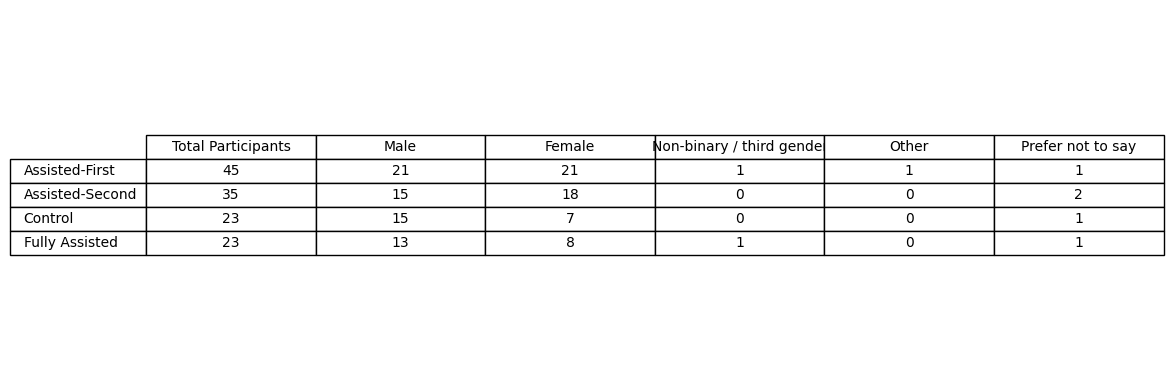

In [30]:
# Group by 'AssignedCondition' and 'Gender' to get counts
gender_distribution = data.groupby(['AssignedCondition', 'Q5']).size().unstack(fill_value=0)

# Add total count of participants in each condition
participant_count = data.groupby('AssignedCondition').size()

# Combine the gender distribution with the total count
result_table = pd.concat([participant_count, gender_distribution], axis=1)
result_table.columns = ['Total Participants', 'Male', 'Female', 'Non-binary / third gender', 'Other', 'Prefer not to say']  # Adjust based on gender column

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size based on your data

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create the table
table = ax.table(
    cellText=result_table.values,
    colLabels=result_table.columns,
    rowLabels=result_table.index,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Scale width and height of cells

# Save the table as a PNG
plt.tight_layout()
plt.savefig("plot-images/participant_gender_table.png", dpi=300, bbox_inches="tight")
plt.show()



In [31]:
# Set up styling
sns.set(style="whitegrid")

# Convert columns to numeric, setting errors='coerce' turns bad values into NaN
data["Q44_2"] = pd.to_numeric(data["Q44_2"], errors="coerce")
data["Q44_3"] = pd.to_numeric(data["Q44_3"], errors="coerce")

# Now you can safely group and average
mean_scores = data.groupby("AssignedCondition")[["Q44_2", "Q44_3"]].mean().reset_index()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2992154477.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2992154477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2992154477.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_3", ax=axes[1], palette="Greens_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2992154477.py:1

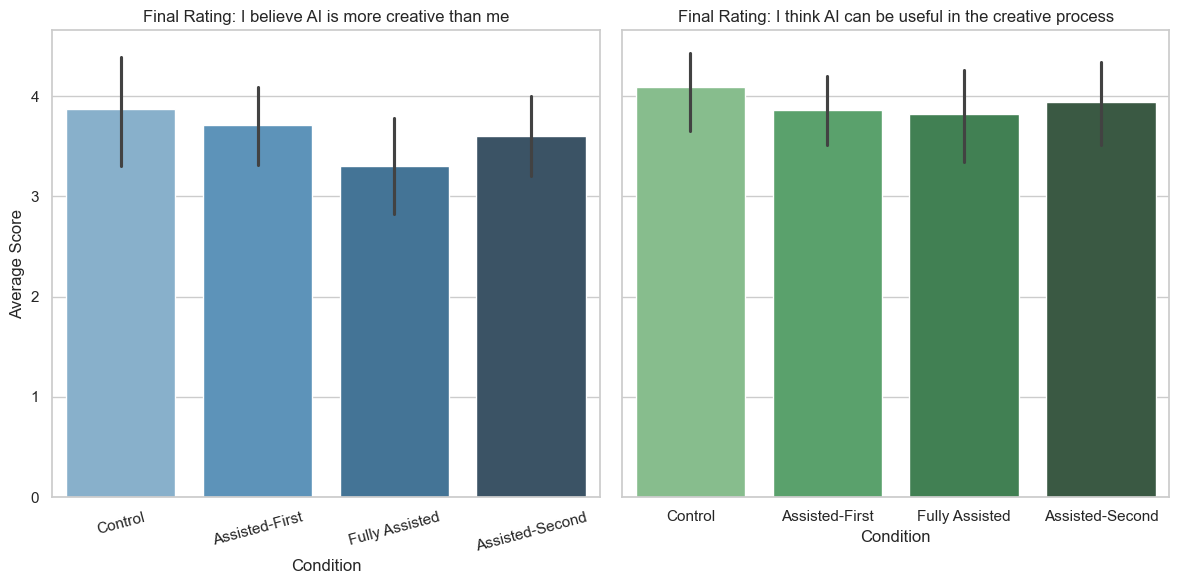

In [32]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Q44_2 Bar Chart: "I believe AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
axes[0].set_title("Final Rating: I believe AI is more creative than me")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Average Score")
axes[0].tick_params(axis='x', rotation=15)

# Q44_3 Bar Chart: "I think AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Q44_3", ax=axes[1], palette="Greens_d", ci=95)
axes[1].set_title("Final Rating: I think AI can be useful in the creative process")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("plot-images/ai_perception_final_ratings.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2499097957.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q26_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2499097957.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q26_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2499097957.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q26_3", ax=axes[1], palette="Greens_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2499097957.py

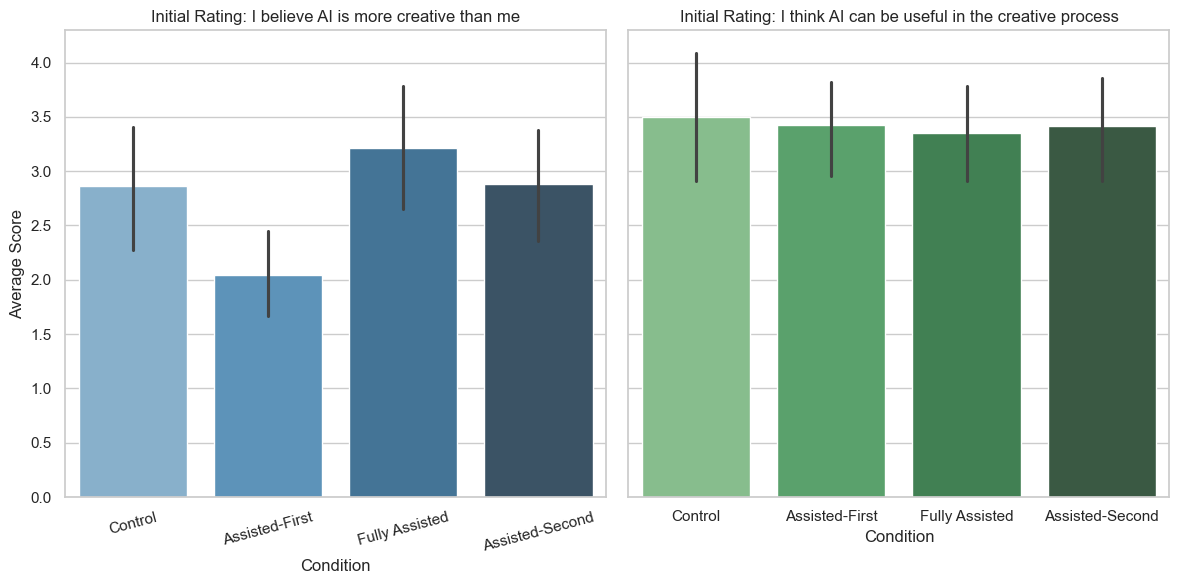

In [33]:
sns.set(style="whitegrid")

# Convert columns to numeric, setting errors='coerce' turns bad values into NaN
data["Q26_2"] = pd.to_numeric(data["Q26_2"], errors="coerce")
data["Q26_3"] = pd.to_numeric(data["Q26_3"], errors="coerce")


fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Q44_2 Bar Chart: "I believe AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Q26_2", ax=axes[0], palette="Blues_d", ci=95)
axes[0].set_title("Initial Rating: I believe AI is more creative than me")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Average Score")
axes[0].tick_params(axis='x', rotation=15)

# Q44_3 Bar Chart: "I think AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Q26_3", ax=axes[1], palette="Greens_d", ci=95)
axes[1].set_title("Initial Rating: I think AI can be useful in the creative process")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("plot-images/ai_perception_pre_ratings.png", dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# Perform ANOVA for Q44_2 (I believe AI is more creative than me)
anova_result_q44_2 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["Q44_2"],
    data[data["AssignedCondition"] == "Fully Assisted"]["Q44_2"],
    data[data["AssignedCondition"] == "Assisted-First"]["Q44_2"],
    data[data["AssignedCondition"] == "Assisted-Second"]["Q44_2"]
)

print("ANOVA for post 'I believe AI is more creative than me':")
print(anova_result_q44_2)

# Perform ANOVA for Q44_3 (I think AI can be useful in the creative process)
anova_result_q44_3 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["Q44_3"],
    data[data["AssignedCondition"] == "Fully Assisted"]["Q44_3"],
    data[data["AssignedCondition"] == "Assisted-First"]["Q44_3"],
    data[data["AssignedCondition"] == "Assisted-Second"]["Q44_3"]
    # Add more conditions as needed
)

print("\nANOVA for post 'I think AI can be useful in the creative process':")
print(anova_result_q44_3)


ANOVA for post 'I believe AI is more creative than me':
F_onewayResult(statistic=np.float64(0.7578775769364504), pvalue=np.float64(0.5198604719759314))

ANOVA for post 'I think AI can be useful in the creative process':
F_onewayResult(statistic=np.float64(0.2365706142854672), pvalue=np.float64(0.870721025928941))


In [35]:
from scipy import stats
import pandas as pd

# Ensure numeric
data["Q26_2"] = pd.to_numeric(data["Q26_2"], errors="coerce")
data["Q26_3"] = pd.to_numeric(data["Q26_3"], errors="coerce")

# Define condition names
conditions = ["Control", "Fully Assisted", "Assisted-First", "Assisted-Second"]

# Extract non-null groups for Q26_2
groups_q26_2 = [data[data["AssignedCondition"] == cond]["Q26_2"].dropna() for cond in conditions]
anova_result_q26_2 = stats.f_oneway(*groups_q26_2)
print("ANOVA for 'I believe AI is more creative than me':")
print(anova_result_q26_2)

# Extract non-null groups for Q26_3
groups_q26_3 = [data[data["AssignedCondition"] == cond]["Q26_3"].dropna() for cond in conditions]
anova_result_q26_3 = stats.f_oneway(*groups_q26_3)
print("\nANOVA for 'I think AI can be useful in the creative process':")
print(anova_result_q26_3)



# Create two groups: "Assisted-First" vs. Everyone Else
group_af = data[data["AssignedCondition"] == "Assisted-First"]
group_other = data[data["AssignedCondition"] != "Assisted-First"]

# T-test for Q44_2: "I believe AI is more creative than me"
t_result_q44_2 = stats.ttest_ind(
    group_af["Q26_2"].dropna(),
    group_other["Q26_2"].dropna(),
    equal_var=False  # Welch's t-test, safer for unequal sample sizes/variances
)

print("T-test for Q26_2 ('I believe AI is more creative than me pre assisted-First vs others'):")
print(t_result_q44_2)

ANOVA for 'I believe AI is more creative than me':
F_onewayResult(statistic=np.float64(4.569439708783752), pvalue=np.float64(0.004564322130009558))

ANOVA for 'I think AI can be useful in the creative process':
F_onewayResult(statistic=np.float64(0.042105341454726816), pvalue=np.float64(0.9884413882390637))
T-test for Q26_2 ('I believe AI is more creative than me pre assisted-First vs others'):
TtestResult(statistic=np.float64(-3.668609777428232), pvalue=np.float64(0.00039608677511839165), df=np.float64(98.32475986181426))


In [36]:
data['Delta_Q2'] = data['Q44_2'] - data['Q26_2']
data['Delta_Q3'] = data['Q44_3'] - data['Q26_3']

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2325610842.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2325610842.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2325610842.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q3", ax=axes[1], palette="Oranges_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2

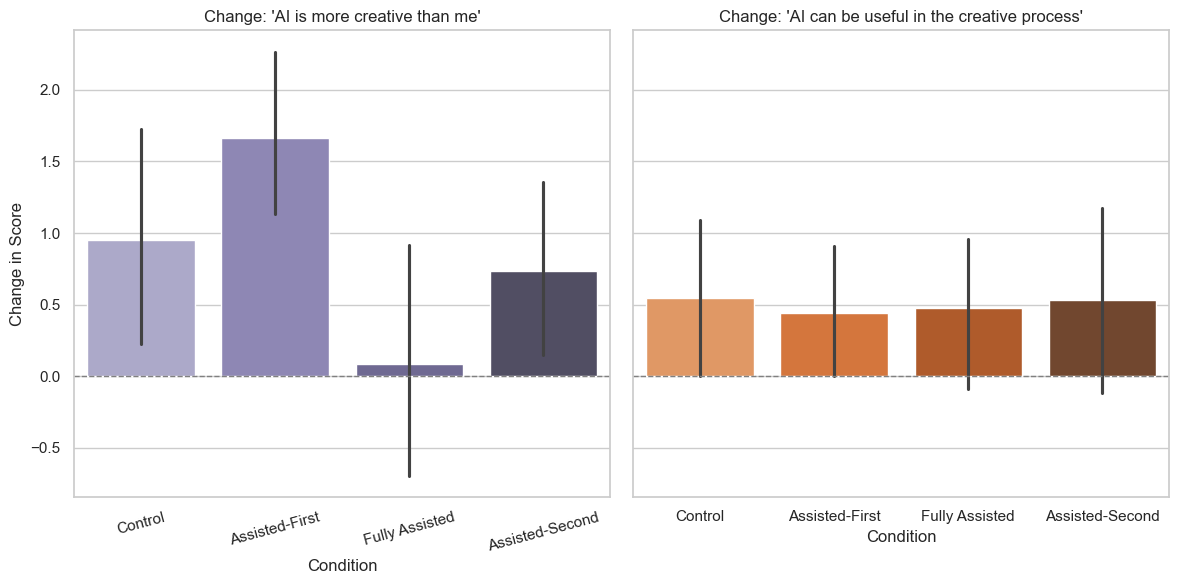

In [37]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Change in "AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
axes[0].set_title("Change: 'AI is more creative than me'")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Change in Score")
axes[0].tick_params(axis='x', rotation=15)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Change in "AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Delta_Q3", ax=axes[1], palette="Oranges_d", ci=95)
axes[1].set_title("Change: 'AI can be useful in the creative process'")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/ai_perception_changes.png", dpi=300, bbox_inches='tight')
plt.show()

In [38]:
data["DATScore"] = pd.to_numeric(data["DATScore"], errors="coerce")  # Ensure numeric
data["DATScore"] = data["DATScore"].fillna(0)  # Replace NaN with 0

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/4287010169.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/4287010169.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)


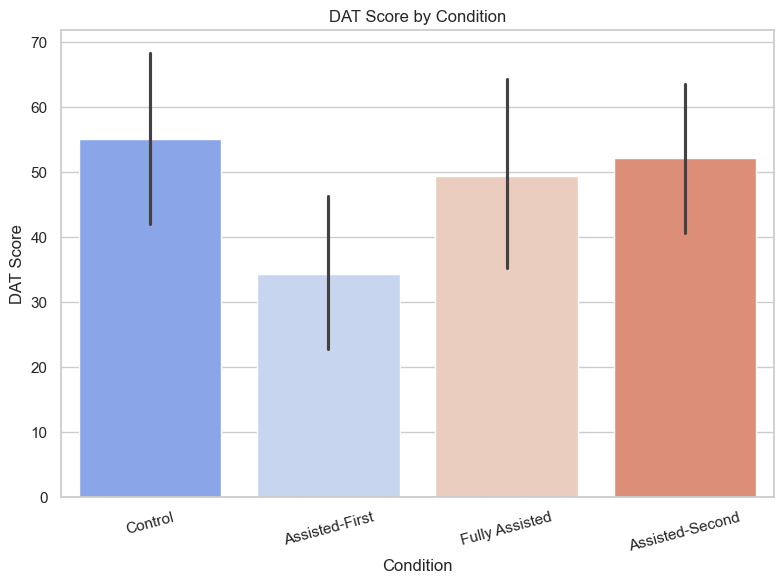

In [39]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)
plt.title("DAT Score by Condition")
plt.xlabel("Condition")
plt.ylabel("DAT Score")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/divergent_association_test_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()


In [40]:
# Ensure DATScore is numeric and replace NaN with 0
data["DATScore"] = pd.to_numeric(data["DATScore"], errors="coerce").fillna(0)

# Check group sizes before running ANOVA
for condition in ["Control", "Fully Assisted", "Assisted-First", "Assisted-Second"]:
    group = data[data["AssignedCondition"] == condition]["DATScore"]
    print(f"{condition}: {len(group)} entries")

# Run ANOVA only if all groups have at least 2 entries
anova_groups = [
    data[data["AssignedCondition"] == "Control"]["DATScore"],
    data[data["AssignedCondition"] == "Fully Assisted"]["DATScore"],
    data[data["AssignedCondition"] == "Assisted-First"]["DATScore"],
    data[data["AssignedCondition"] == "Assisted-Second"]["DATScore"]
]

if all(len(group.dropna()) > 1 for group in anova_groups):
    anova_result_q44_2 = stats.f_oneway(*anova_groups)
    print("ANOVA for DAT score:")
    print(anova_result_q44_2)
else:
    print("Not enough data in one or more groups to perform ANOVA.")


Control: 23 entries
Fully Assisted: 23 entries
Assisted-First: 45 entries
Assisted-Second: 35 entries
ANOVA for DAT score:
F_onewayResult(statistic=np.float64(2.371970313518861), pvalue=np.float64(0.07369668105186833))


In [41]:
from scipy.stats import ttest_ind

assisted_first = data[data["AssignedCondition"] == "Assisted-First"]["DATScore"]
control = data[data["AssignedCondition"] == "Control"]["DATScore"]
fully_assisted = data[data["AssignedCondition"] == "Fully Assisted"]["DATScore"]
assisted_second = data[data["AssignedCondition"] == "Assisted-Second"]["DATScore"]

print("Assisted-First vs Control:", ttest_ind(assisted_first, control, equal_var=False))
print("Assisted-First vs Fully Assisted:", ttest_ind(assisted_first, fully_assisted, equal_var=False))
print("Assisted-First vs Assisted-Second:", ttest_ind(assisted_first, assisted_second, equal_var=False))


Assisted-First vs Control: TtestResult(statistic=np.float64(-2.278322172361474), pvalue=np.float64(0.026999664876571773), df=np.float64(50.16785008865683))
Assisted-First vs Fully Assisted: TtestResult(statistic=np.float64(-1.5690966674473819), pvalue=np.float64(0.12342094589269545), df=np.float64(46.39745711390608))
Assisted-First vs Assisted-Second: TtestResult(statistic=np.float64(-2.128162538365228), pvalue=np.float64(0.036583693151851546), df=np.float64(75.57255790445426))


In [42]:
# Group: Assisted-First
assisted_first = data[data["AssignedCondition"] == "Assisted-First"]["DATScore"]

# Group: Fully Assisted + Assisted-Second
later_assisted = data[data["AssignedCondition"].isin(["Fully Assisted", "Assisted-Second"])]["DATScore"]

# Welch’s t-test (no assumption of equal variances)
t_stat, p_value = ttest_ind(assisted_first, later_assisted, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.243631093505244, P-value: 0.027278541874157684


### What if there were no zeros at all allowed on the DAT Score?

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2593116631.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=filtered_data, x="AssignedCondition", y="DATScoreOneWord", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2593116631.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_data, x="AssignedCondition", y="DATScoreOneWord", palette="coolwarm", ci=95)


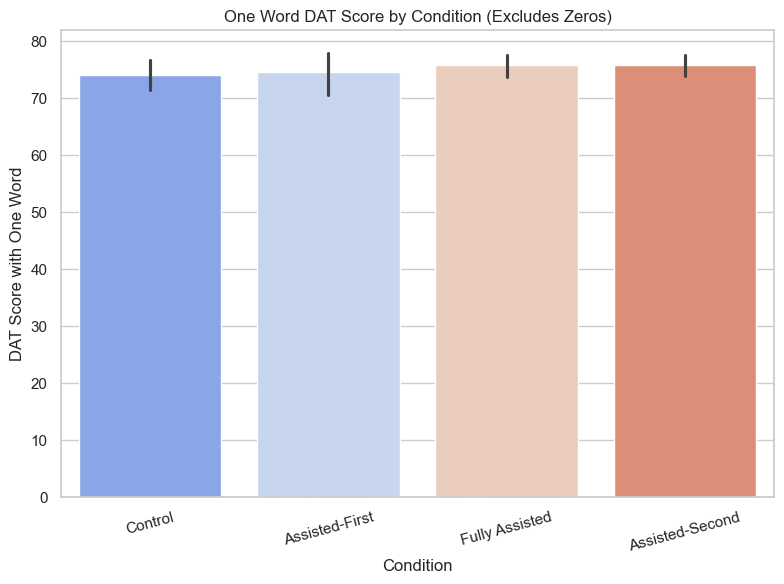

In [43]:
# Step 1: Filter out participants with DATScoreOneWord == 0
filtered_data = data[data["DATScoreOneWord"] > 0]

# Step 2: Plot using the filtered data
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=filtered_data, x="AssignedCondition", y="DATScoreOneWord", palette="coolwarm", ci=95)
plt.title("One Word DAT Score by Condition (Excludes Zeros)")
plt.xlabel("Condition")
plt.ylabel("DAT Score with One Word")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/divergent_association_test_one_word_by_condition_no_zeros.png", dpi=300, bbox_inches='tight')
plt.show()


In [44]:
# Step 1: Filter out zero scores
filtered_data = data[data["DATScoreOneWord"] > 0]

# Step 2: Group the data by condition
groups = filtered_data.groupby("AssignedCondition")["DATScoreOneWord"]

# Step 3: Extract the scores into separate lists for each condition
group_scores = [group.tolist() for name, group in groups]

# Step 4: Run one-way ANOVA
f_stat, p_value = f_oneway(*group_scores)

# Step 5: Print the results
print(f"ANOVA results: F = {f_stat:.4f}, p = {p_value:.4f}")

ANOVA results: F = 0.3565, p = 0.7846


#### DAT Score by Combined Condition

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1817108798.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1817108798.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)


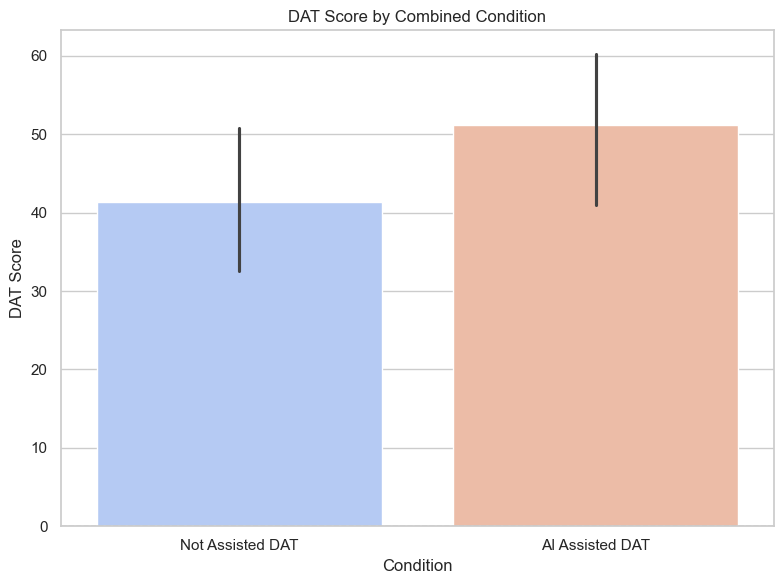

In [45]:
# Create a new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Fully Assisted': 'AI Assisted DAT',
    'Assisted-Second': 'AI Assisted DAT',
    'Assisted-First': 'Not Assisted DAT',
    'Control': 'Not Assisted DAT'
})

# Plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)

plt.title("DAT Score by Combined Condition")
plt.xlabel("Condition")
plt.ylabel("DAT Score")
# plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Save the figure
import os
os.makedirs("plot-images", exist_ok=True)
plt.tight_layout()
plt.savefig("plot-images/divergent_association_test_binary_condition.png", dpi=300, bbox_inches='tight')
plt.show()

In [46]:
# Create a new combined condition column
data['DATCombinedCondition'] = data['AssignedCondition'].replace({
    'Fully Assisted': 'AI Assisted DAT',
    'Assisted-Second': 'AI Assisted DAT',
    'Assisted-First': 'Not Assisted DAT',
    'Control': 'Not Assisted DAT'
})

# Filter data into two groups based on 'CombinedCondition'
ai_assisted_dat = data[data['DATCombinedCondition'] == 'AI Assisted DAT']['DATScore']
not_assisted_dat = data[data['DATCombinedCondition'] == 'Not Assisted DAT']['DATScore']

print("AI Assisted DAT group size:", ai_assisted_dat.shape)
print("Not Assisted DAT group size:", not_assisted_dat.shape)


# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_dat.dropna(), not_assisted_dat.dropna())

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

AI Assisted DAT group size: (58,)
Not Assisted DAT group size: (68,)
T-test result: t-statistic = 1.463, p-value = 0.146


In [47]:
# Filter to rows where DATScore is 0
dat_zero_df = data[data["DATScore"] == 0]

# 1. Number of zeros per DATCombinedCondition
zero_counts_combined = dat_zero_df["DATCombinedCondition"].value_counts()

# 2. Total counts per DATCombinedCondition
total_counts_combined = data["DATCombinedCondition"].value_counts()

# 3. Proportion of zeros per DATCombinedCondition
proportion_combined = zero_counts_combined / total_counts_combined

# Display results for combined conditions
print("=== DATCombinedCondition ===")
for condition in total_counts_combined.index:
    zeros = zero_counts_combined.get(condition, 0)
    total = total_counts_combined[condition]
    proportion = proportion_combined.get(condition, 0)
    print(f"{condition}: {zeros} zeros out of {total} total ({proportion:.2%})")

# 4. Number of zeros per original AssignedCondition
zero_counts_individual = dat_zero_df["AssignedCondition"].value_counts()

# 5. Total counts per AssignedCondition
total_counts_individual = data["AssignedCondition"].value_counts()

# 6. Proportion of zeros per AssignedCondition
proportion_individual = zero_counts_individual / total_counts_individual

# Display results for individual conditions
print("\n=== AssignedCondition ===")
for condition in total_counts_individual.index:
    zeros = zero_counts_individual.get(condition, 0)
    total = total_counts_individual[condition]
    proportion = proportion_individual.get(condition, 0)
    print(f"{condition}: {zeros} zeros out of {total} total ({proportion:.2%})")


=== DATCombinedCondition ===
Not Assisted DAT: 31 zeros out of 68 total (45.59%)
AI Assisted DAT: 19 zeros out of 58 total (32.76%)

=== AssignedCondition ===
Assisted-First: 25 zeros out of 45 total (55.56%)
Assisted-Second: 11 zeros out of 35 total (31.43%)
Control: 6 zeros out of 23 total (26.09%)
Fully Assisted: 8 zeros out of 23 total (34.78%)


In [48]:
from scipy.stats import fisher_exact

# Your raw data
zero_data = {
    'Blank/Incomplete': [12, 4, 3, 2],
    'Meme/Nonsense': [1, 1, 0, 1],
    'Misunderstanding': [15, 7, 5, 5],
    'Total': [45, 35, 23, 23]
}

df = pd.DataFrame(zero_data, index=['Assisted-First', 'Assisted-Second', 'Control', 'Fully Assisted'])

# Helper function to run Fisher’s Exact Test
def run_fisher_test(df, category):
    af_count = df.loc['Assisted-First', category]
    af_total = df.loc['Assisted-First', 'Total']
    
    other_count = df.drop('Assisted-First')[category].sum()
    other_total = df.drop('Assisted-First')['Total'].sum()
    
    # Build 2x2 table
    table = [[af_count, af_total - af_count],
             [other_count, other_total - other_count]]
    
    # Run Fisher’s Exact Test
    oddsratio, p = fisher_exact(table, alternative='greater')  # 'greater' tests if AF is higher
    print(f"Fisher’s Exact Test for '{category}':")
    print(f"  Odds Ratio (F-score): {oddsratio:.3f}")
    print(f"  P-value: {p:.4f}\n")

# Run the test for each category
run_fisher_test(df, 'Blank/Incomplete')
run_fisher_test(df, 'Meme/Nonsense')
run_fisher_test(df, 'Misunderstanding')

Fisher’s Exact Test for 'Blank/Incomplete':
  Odds Ratio (F-score): 2.909
  P-value: 0.0246

Fisher’s Exact Test for 'Meme/Nonsense':
  Odds Ratio (F-score): 0.898
  P-value: 0.7379

Fisher’s Exact Test for 'Misunderstanding':
  Odds Ratio (F-score): 1.882
  P-value: 0.0957



### What if we exclude all zeros

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/341666325.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=filtered_data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/341666325.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)


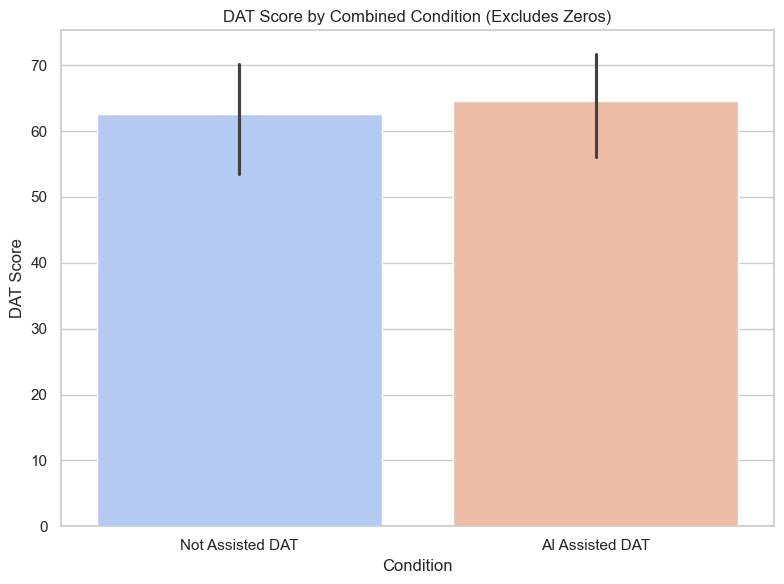

In [49]:
# Create a new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Fully Assisted': 'AI Assisted DAT',
    'Assisted-Second': 'AI Assisted DAT',
    'Assisted-First': 'Not Assisted DAT',
    'Control': 'Not Assisted DAT'
})

filtered_data = data[data["DATScoreOneWord"] > 0]


# Plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(data=filtered_data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)

plt.title("DAT Score by Combined Condition (Excludes Zeros)")
plt.xlabel("Condition")
plt.ylabel("DAT Score")
# plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Save the figure
import os
os.makedirs("plot-images", exist_ok=True)
plt.tight_layout()
plt.savefig("plot-images/divergent_association_test_binary_condition_no_zeros.png", dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# Create a new combined condition column
data['DATCombinedCondition'] = data['AssignedCondition'].replace({
    'Fully Assisted': 'AI Assisted DAT',
    'Assisted-Second': 'AI Assisted DAT',
    'Assisted-First': 'Not Assisted DAT',
    'Control': 'Not Assisted DAT'
})

filtered_data = data[data["DATScoreOneWord"] > 0]

# Filter data into two groups based on 'CombinedCondition'
ai_assisted_dat = filtered_data[filtered_data['DATCombinedCondition'] == 'AI Assisted DAT']['DATScore']
not_assisted_dat = filtered_data[filtered_data['DATCombinedCondition'] == 'Not Assisted DAT']['DATScore']

print("AI Assisted DAT group size:", ai_assisted_dat.shape)
print("Not Assisted DAT group size:", not_assisted_dat.shape)


# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_dat.dropna(), not_assisted_dat.dropna())

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

AI Assisted DAT group size: (46,)
Not Assisted DAT group size: (45,)
T-test result: t-statistic = 0.327, p-value = 0.744


## Fluency Calculation and Visualization

In [51]:
data = calculate_fluency_scores(data)

In [52]:
fluency_cols = ['Fluency1', 'Fluency2', 'Fluency3', 'Fluency4', 'Fluency5']
data['FluencyAverage'] = data[fluency_cols].mean(axis=1)

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/3185752355.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/3185752355.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)


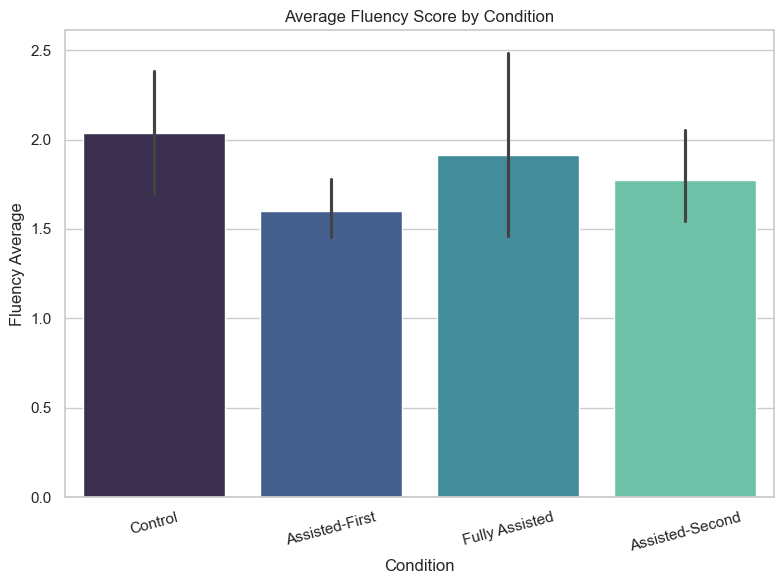

In [53]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)
plt.title("Average Fluency Score by Condition")
plt.xlabel("Condition")
plt.ylabel("Fluency Average")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/fluency_average_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/738436888.py:21: SyntaxWarning: invalid escape sequence '\d'
  df_long['Trial'] = df_long['Trial'].str.extract('(\d)').astype(int)


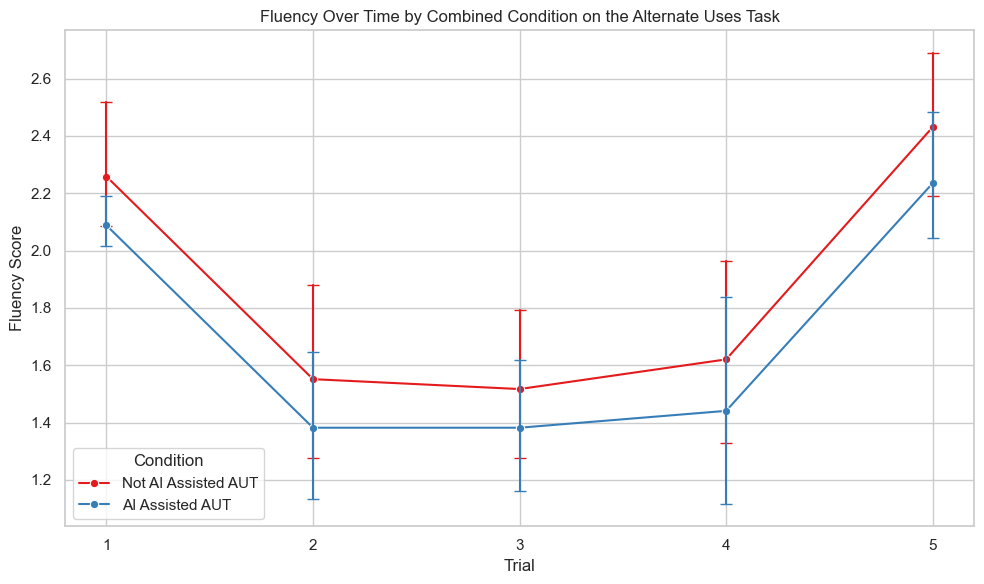

In [54]:
# Define fluency columns
fluency_cols = ['Fluency1', 'Fluency2', 'Fluency3', 'Fluency4', 'Fluency5']

# Create new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Control': 'Not AI Assisted AUT',
    'Assisted-Second': 'Not AI Assisted AUT',
    'Assisted-First': 'AI Assisted AUT',
    'Fully Assisted': 'AI Assisted AUT'
})

# Melt the DataFrame to long format
df_long = data.melt(
    id_vars='CombinedCondition',
    value_vars=fluency_cols,
    var_name='Trial',
    value_name='Fluency'
)

# Extract the trial number (1–5)
df_long['Trial'] = df_long['Trial'].str.extract('(\d)').astype(int)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_long,
    x="Trial",
    y="Fluency",
    hue="CombinedCondition",
    marker="o",
    errorbar=("ci", 95),
    palette="Set1",
    err_style="bars",  # explicitly use bars instead of band
    err_kws={"capsize": 4}  # optional: adds caps to error bars
)

plt.title("Fluency Over Time by Combined Condition on the Alternate Uses Task")
plt.xlabel("Trial")
plt.ylabel("Fluency Score")
plt.xticks(ticks=range(1, 6))
plt.legend(title="Condition")
plt.tight_layout()

# Save the plot
os.makedirs("plot-images", exist_ok=True)
plt.savefig("plot-images/fluency_over_time_combined.png", dpi=300, bbox_inches='tight')
plt.show()

126 126


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1752904173.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1752904173.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


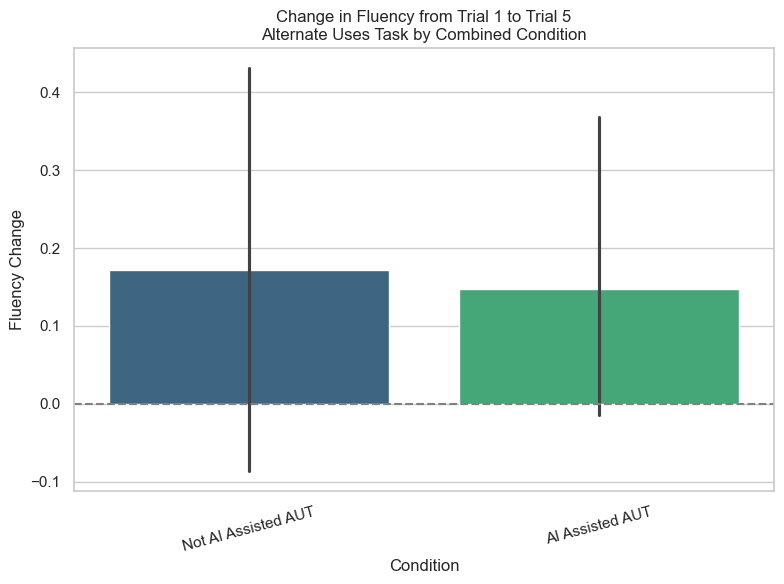

In [55]:
print(len(data['Fluency5']), len(data['Fluency1']))

data['FluencyChange'] = data['Fluency5'] - data['Fluency1']

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(
    data=data,
    x="CombinedCondition",
    y="FluencyChange",
    palette="viridis",
    ci=95
)

plt.title("Change in Fluency from Trial 1 to Trial 5\nAlternate Uses Task by Combined Condition")
plt.xlabel("Condition")
plt.ylabel("Fluency Change")
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=15)
plt.tight_layout()

# Save plot
os.makedirs("plot-images", exist_ok=True)
plt.savefig("plot-images/fluency_change_combined_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [56]:
# Create a new combined condition column
# Create new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Control': 'Not AI Assisted AUT',
    'Assisted-Second': 'Not AI Assisted AUT',
    'Assisted-First': 'AI Assisted AUT',
    'Fully Assisted': 'AI Assisted AUT'
})

# Filter data into two groups based on 'CombinedCondition'
ai_assisted_aut = data[data['CombinedCondition'] == 'AI Assisted AUT']['FluencyChange']
not_assisted_aut = data[data['CombinedCondition'] == 'Not AI Assisted AUT']['FluencyChange']

print("AI Assisted AUT group size:", ai_assisted_aut.shape)
print("Not Assisted AUT group size:", not_assisted_aut.shape)


# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_aut.dropna(), not_assisted_aut.dropna())

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

AI Assisted AUT group size: (68,)
Not Assisted AUT group size: (58,)
T-test result: t-statistic = -0.156, p-value = 0.876


## Originality Scores

In [57]:
# Translation dictionary
translation_dict = {
    "garrafa": "bottle",
    "pneu": "tire",
    "mesa": "table",
    "sapato": "shoe",
    "calça": "pair of pants"
}

# Columns to apply translation to
item_columns = ["Item1", "Item2", "Item3", "Item4", "Item5"]

# Apply translation
data[item_columns] = data[item_columns].replace(translation_dict)

In [58]:
# Initialize new columns
data['tableUses'] = ""
data['tireUses'] = ""
data['bottleUses'] = ""
data['pantsUses'] = ""
data['shoeUses'] = ""

# Iterate through rows
for idx, row in data.iterrows():
    for i in range(1, 6):
        item = str(row[f'Item{i}']).strip().lower()
        use = row[f'AlternateUsesTask{i}']
        
        if item == "table":
            data.at[idx, 'tableUses'] = use
        elif item == "tire":
            data.at[idx, 'tireUses'] = use
        elif item == "bottle":
            data.at[idx, 'bottleUses'] = use
        elif item in ["pair of pants", "pants"]:
            data.at[idx, 'pantsUses'] = use
        elif item == "shoe":
            data.at[idx, 'shoeUses'] = use


item_names = ['table', 'tire', 'bottle', 'pair of pants', 'shoe']
item_columns = ['Item1', 'Item2', 'Item3', 'Item4', 'Item5']
uses_columns = ['AlternateUsesTask1', 'AlternateUsesTask2', 'AlternateUsesTask3', 'AlternateUsesTask4', 'AlternateUsesTask5']

In [59]:
def extract_ratings_list(response):
    if not response:
        return []
    ratings = re.findall(r"\b(10|[1-9])\b", response)
    return [int(r) for r in ratings]

In [60]:
def call_openai_gpt(prompt):
    client = openai.OpenAI(api_key=OPEN_AI_KEY)
    response = client.responses.create(
        model="gpt-4o",
        input = prompt
    )
    # print(response.output_text)
    return response.output_text

In [61]:
item_names = ['table', 'tire', 'bottle', 'pair of pants', 'shoe']
all_item_uses = {}

# Step 1: Aggregate all uses for each item
for item in item_names:
    all_uses = []

    for idx, row in data.iterrows():
        for i in range(5):
            if row[item_columns[i]] == item:
                uses_string = row[uses_columns[i]]
                if pd.notna(uses_string):
                    split_uses = [u.strip() for u in uses_string.split(";") if u.strip()]
                    all_uses.extend(split_uses)

    # Optional: remove duplicates
    unique_uses = list(set(all_uses))
    all_item_uses[item] = unique_uses


In [62]:
def build_prompt(item, uses):
    prompt = f"Below is a list of uses for a {item}. On a scale of 1–10, judge how original each use for a {item} is, where 1 is 'not at all creative' and 10 is 'very creative'.\n\n"
    for idx, use in enumerate(uses, 1):
        prompt += f"{idx}. {use}\n"
    return prompt


#### The following runs GPT 4o here - be careful when running since it does charge a couple of cents per run!

In [63]:
item_scores = {}
item_raw_responses = {}

# uncomment the following lines in order to run GPT to evaluate all of the different uses! Comment after you're done
# Step 3: Call GPT once per item
for item, uses in all_item_uses.items():
    prompt = build_prompt(item, uses)
    response = call_openai_gpt(prompt)  # <-- Your API call here
    item_raw_responses[item] = response

    scores = extract_ratings_list(response)
    item_scores[item] = dict(zip(uses, scores))
    print("done with one object!")

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: your key*here. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [ ]:
for item in item_names:
    creativity_ratings = []

    for idx, row in data.iterrows():
        participant_uses = []
        for i in range(5):
            if row[item_columns[i]] == item:
                uses_string = row[uses_columns[i]]
                if pd.notna(uses_string):
                    split_uses = [u.strip() for u in uses_string.split(";") if u.strip()]
                    participant_uses.extend(split_uses)

        if participant_uses:
            # Use pre-scored values
            scores = [item_scores[item].get(use, None) for use in participant_uses]
            avg_score = sum(s for s in scores if s is not None) / len(scores) if scores else None
        else:
            avg_score = None

        creativity_ratings.append(avg_score)

    data[f"{item}CreativityRating"] = creativity_ratings


In [ ]:
print(data['shoeCreativityRating'])
print(data['pair of pantsCreativityRating'])
print(data['tableCreativityRating'])
print(data['bottleCreativityRating'])
print(data['tireCreativityRating'])

18     6.00
19     7.00
20     5.00
21     4.00
22     1.00
       ... 
160    3.00
161    1.00
162    1.75
163    1.00
164    4.00
Name: shoeCreativityRating, Length: 126, dtype: float64
18     NaN
19     1.0
20     5.0
21     6.0
22     6.0
      ... 
160    2.0
161    2.0
162    4.0
163    NaN
164    1.0
Name: pair of pantsCreativityRating, Length: 126, dtype: float64
18     1.0
19     1.0
20     2.0
21     3.0
22     6.0
      ... 
160    7.0
161    1.0
162    3.2
163    2.0
164    9.0
Name: tableCreativityRating, Length: 126, dtype: float64
18     0.000000
19     1.000000
20     1.000000
21     1.000000
22     1.000000
         ...   
160    0.000000
161    0.000000
162    0.333333
163    5.000000
164    1.000000
Name: bottleCreativityRating, Length: 126, dtype: float64
18     5.0
19     6.0
20     4.0
21     4.0
22     1.0
      ... 
160    1.0
161    5.0
162    2.0
163    5.0
164    6.0
Name: tireCreativityRating, Length: 126, dtype: float64


In [ ]:
# Define a function to get the creativity rating for a specific item column
def get_creativity_rating(row, item_col):
    item = row[item_col]
    rating_col = f"{item}CreativityRating"
    return row.get(rating_col, None)

# Apply this function for Item1 to Item5
for i in range(1, 6):
    data[f"AUTOriginality{i}"] = data.apply(lambda row: get_creativity_rating(row, f"Item{i}"), axis=1)


In [ ]:
originality_cols = ['AUTOriginality1', 'AUTOriginality2', 'AUTOriginality3', 'AUTOriginality4', 'AUTOriginality5']

# Replace empty strings with NaN, then fill NaN with 0, and convert to numeric
data[originality_cols] = data[originality_cols].replace('', np.nan).fillna(0).apply(pd.to_numeric, errors='coerce')
print(data['AUTOriginality1'])

18     0.0
19     7.0
20     5.0
21     3.0
22     6.0
      ... 
160    0.0
161    0.0
162    2.0
163    0.0
164    1.0
Name: AUTOriginality1, Length: 126, dtype: float64


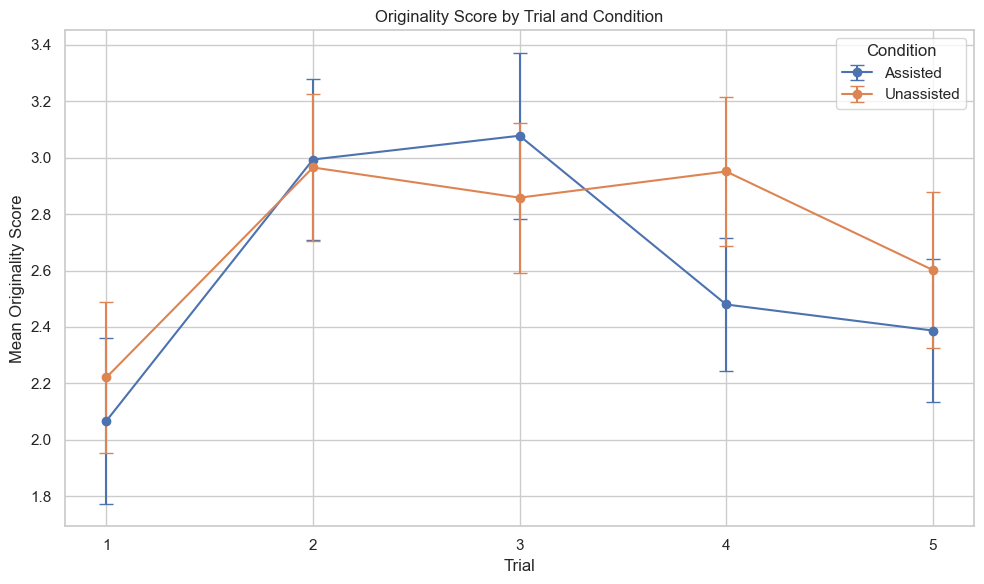

In [ ]:
# First, define the mapping
def map_combined_condition(cond):
    if cond in ['Assisted-First', 'Fully Assisted']:
        return 'Assisted'
    else:
        return 'Unassisted'

# Apply the mapping
data['CombinedCondition'] = data['AssignedCondition'].map(map_combined_condition)

# Melt the data to long format for easier plotting
melted = data.melt(
    id_vars='CombinedCondition',
    value_vars=[f'AUTOriginality{i}' for i in range(1, 6)],
    var_name='Trial',
    value_name='OriginalityScore'
)

# Aggregate: compute mean and standard error
summary = (
    melted
    .groupby(['CombinedCondition', 'Trial'])
    .agg(mean_score=('OriginalityScore', 'mean'),
         sem_score=('OriginalityScore', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))))
    .reset_index()
)

# Convert 'AUTOriginality1' to 1, 'AUTOriginality2' to 2, etc.
summary['Trial'] = summary['Trial'].str.extract(r'(\d)').astype(int)

# Plot
plt.figure(figsize=(10, 6))
for condition in summary['CombinedCondition'].unique():
    subset = summary[summary['CombinedCondition'] == condition]
    plt.errorbar(
        subset['Trial'],
        subset['mean_score'],
        yerr=subset['sem_score'],
        label=condition,
        marker='o',
        capsize=5
    )

plt.title('Originality Score by Trial and Condition')
plt.xlabel('Trial')
plt.ylabel('Mean Originality Score')
plt.xticks([1, 2, 3, 4, 5])  # Set custom x-axis ticks
plt.legend(title='Condition')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot-images/originality_aut_over_time_combined_condition.png", dpi=300, bbox_inches='tight')
plt.show()


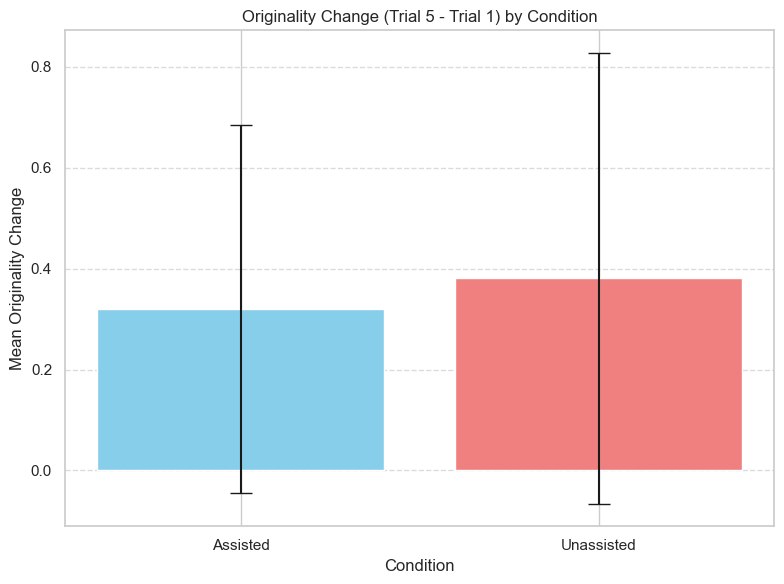

In [ ]:
# Calculate the change from Trial 1 to Trial 5
data["OriginalityChange"] = data["AUTOriginality5"] - data["AUTOriginality1"]

# Group and summarize
change_summary = (
    data.groupby("CombinedCondition")["OriginalityChange"]
    .agg(mean_change='mean', sem_change=lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(
    change_summary['CombinedCondition'],
    change_summary['mean_change'],
    yerr=change_summary['sem_change'],
    capsize=8,
    color=['skyblue', 'lightcoral']
)

plt.title("Originality Change (Trial 5 - Trial 1) by Condition")
plt.ylabel("Mean Originality Change")
plt.xlabel("Condition")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plot-images/originality_change_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
data['OriginalityChange'] = pd.to_numeric(
    data['OriginalityChange'].replace('', np.nan),  # Replace empty strings with NaN
    errors='coerce'  # Convert any non-numeric value to NaN
)

# Then, fill NaN values with 0
data['OriginalityChange'].fillna(0, inplace=True)


ai_assisted_aut = data[data['CombinedCondition'] == 'Assisted']['OriginalityChange']
not_assisted_aut = data[data['CombinedCondition'] == 'Unassisted']['OriginalityChange']

# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_aut, not_assisted_aut)

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")


T-test result: t-statistic = -0.106, p-value = 0.915


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_51259/1804478745.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['OriginalityChange'].fillna(0, inplace=True)


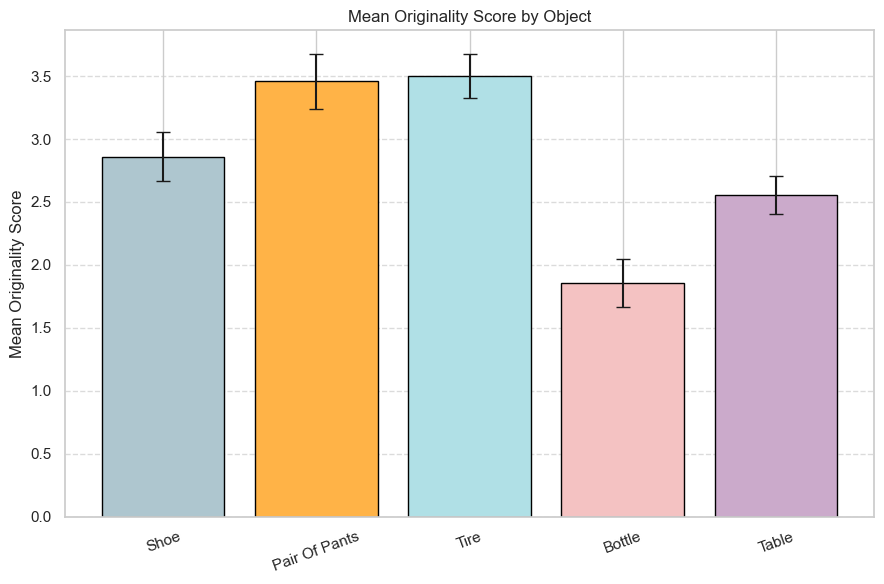

In [ ]:
# Define pastel colors (manually selected or from seaborn palette)
pastel_colors = ['#aec6cf', '#ffb347', '#b0e0e6', '#f4c2c2', '#cbaacb']

# List of the creativity rating columns
creativity_columns = [
    'shoeCreativityRating',
    'pair of pantsCreativityRating',
    'tireCreativityRating',
    'bottleCreativityRating',
    'tableCreativityRating'
]

# Calculate means and SEMs
mean_scores = data[creativity_columns].mean()
sem_scores = data[creativity_columns].apply(sem, nan_policy='omit')

# Clean up the labels for display
labels = [col.replace('CreativityRating', '').title() for col in creativity_columns]

# Plot
plt.figure(figsize=(9, 6))
bars = plt.bar(labels, mean_scores, yerr=sem_scores, capsize=5,
               color=pastel_colors, edgecolor='black')

plt.ylabel('Mean Originality Score')
plt.title('Mean Originality Score by Object')
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plot-images/originality_per_object.png", dpi=300, bbox_inches='tight')
plt.show()

## Flexibility Rating and Visualization

#### Run the following for flexibility ratings: it does cost some money!

In [ ]:
def get_categories(item, responses):
    prompt = (
        f"In a recent study, students were given the AUT test for the following object: {item}.\n"
        f"The following responses were given: {responses}.\n"
        "Please examine the responses and determine the distinct categories into which you would assign the responses.\n"
        "Output only the category names. I would like the number of categories to be between 15 and 20.\n"
        "Return the list of categories, one per line. Do not include numbering, quotes, or examples—only the name of each category."
    )
    return prompt


def assign_categories(item, responses, categories):
    """
    Prepares a GPT prompt to categorize responses for multiple participants while keeping them separable.
    Ensures each participant block is clearly delimited to prevent merging.
    """
    all_prompts = ""

    for idx, response_str in enumerate(responses):
        individual_uses = [use.strip() for use in response_str.split(';') if use.strip()]

        if not individual_uses or not is_valid_response(response_str):
            prompt = (
                f"### Participant {idx+1}:\n"
                f"No responses were given for the object: {item}.\n"
                f"Output ONLY the phrase: NO RESPONSE.\n\n"
                f"(Separate each participant's output with TWO newlines.)\n"
            )
        else:
            uses_text = "\n".join(f"{i+1}. {use}" for i, use in enumerate(individual_uses))
            prompt = (
                f"### Participant {idx+1}:\n"
                f"Object: {item}\n"
                f"Responses:\n{uses_text}\n\n"
                f"Assign ONE category from the list below to EACH response:\n{categories}\n\n"
                f"Respond with ONLY the category names, one per line, in the SAME ORDER as the responses.\n"
                f"Do NOT include any numbers, quotation marks, or repeated responses.\n"
                f"Do NOT add explanations or comments.\n"
                f"AFTER EACH PARTICIPANT'S OUTPUT, insert TWO NEWLINES to separate them.\n"
            )

        all_prompts += prompt + "\n"

    return all_prompts


def parse_flexibility_categories(gpt_output, num_participants):
    """
    Parses GPT output into flexibility scores, ensuring alignment with input participants.
    Returns a list of flexibility scores where each index matches the original input index.
    Missing or malformed blocks are treated as 0 (i.e., 'NO RESPONSE').
    """
    # Split GPT output using participant header
    pattern = r"### Participant (\d+):\n"
    blocks = re.split(pattern, gpt_output.strip())
    
    flexibility_scores = [0] * num_participants  # Default to 0 for all

    # blocks[0] is the preamble (if any); remaining blocks follow the pattern [id, content, id, content, ...]
    for i in range(1, len(blocks), 2):
        try:
            participant_idx = int(blocks[i]) - 1  # Convert participant ID to 0-based index
            content = blocks[i + 1].strip()
            lines = [line.strip() for line in content.splitlines() if line.strip()]

            if len(lines) == 1 and lines[0].upper() == "NO RESPONSE":
                flexibility_scores[participant_idx] = 0
            else:
                flexibility_scores[participant_idx] = len(set(lines))
        except Exception as e:
            print(f"Error parsing participant {i//2 + 1}: {e}")
            continue  # Keeps score as 0 by default

    return flexibility_scores



def is_valid_response(response_str):
    """
    Checks if a participant's response is non-empty and doesn't consist solely of 'nan' entries.
    """
    if pd.isna(response_str) or response_str.strip() == '':
        return False
    parts = [p.strip().lower() for p in response_str.split(';')]
    return any(p not in ('', 'nan') for p in parts)



def get_batched_flexibility_scores(df, item, col_name):
    use_series = df[col_name].replace('', np.nan)  # Replace empty strings with NaN
    use_series = use_series.replace('nan; nan', np.nan)
    use_series = use_series.fillna('')
    index_list = use_series.index.tolist()
    responses = use_series.tolist()
    print('Responses: ', responses)

    # STEP 1: Get categories from GPT
    prompt = get_categories(item, responses)
    categories = call_openai_gpt(prompt)

    # STEP 2: Assign categories to each use
    new_prompt = assign_categories(item, responses, categories)
    content = call_openai_gpt(new_prompt)

    # STEP 3: Parse and count unique categories per participant
    scores = parse_flexibility_categories(content, len(responses))

    # STEP 4: Align scores back to original DataFrame
    result_series = pd.Series([None] * len(df), index=df.index)
    for i, idx in enumerate(index_list):
        if i < len(scores):
            result_series.loc[idx] = scores[i]

    return result_series

In [ ]:
data['shoeFlexibility'] = get_batched_flexibility_scores(data, 'shoe', 'shoeUses')


Responses:  ['usar pra não se machucar o pé', 'no pe e na mão;', 'para colocar no pe', 'CORRER;', 'tenis bota', 'podemos calsar ele; podemos usar como carrinho de bonecos pequenos', 'para cauça stdtd', '1;', 'para nao ficar descalço', 'para calça;', 'usar, andar;', 'para corre para botar no pe para sair passear pra ir trabalha', 'calçar, amarrar , jogar no lixo, entregar, limpar, colocar jogar bola e queimado;', 'Usar nos Pés , Usar para Bonecos ( Como Aqueles de Loja de Roupa ) , etc.', 'para ir para os lugares para ir para a escola para correr e ets; 3', '4', 'correr; andar; pular; calçar', 'nao', 'correr, colocar no pé, usar para correr, usar com meia.', 'para correr; para treinar; para montar um look', 'para calçar no pe e fazer atividades fisicas;', 'eu posso colocar no pe e posso colocar plantas e posso usar para outras coisas tambem;', 'tenis; sapatilha; cadarço; chao; pular; correr', 'usa e impor tan te;', ';', 'CAUSAR DIA A DIA PARA MALHAR OU TRABALHAR;', 'elepo;', 'para prote

In [ ]:
data['pantsFlexibility'] = get_batched_flexibility_scores(data, 'pair of pants', 'pantsUses')


Responses:  [';', 'nas pernas', 'vestir;', 'FAZER UMA BERMUDA', 'calça shorts se for cortada', 'podemos usar ela ou vestir; podemos fazer uma bandeira de um castelo com ela', 'para vestir no corpo', 'pode usar ela dobrada na perna e também pode corta ela para fazer de bermuda', 'para nao facar com frio nas pernas', 'para calça', 'vestir,lavar;', 'para sair pra ir no sitio pra ir no trabalho ir para a escola pra botar', 'colocar, cortar, abotoar, materializar, colocar a mao no bolso, colocar dinheiro no bolso, dobrar, desdobrar, sujar,', 'Vestir , Recortar e usar em outras utilidades ( Shorts , jaquetas ... ) Secar lugar Umido e etc.', 'para ir para a escola para ir para o shoopin para ir trabalhar ets; 3', '9', ';', 'claro', 'vestir, guardar algo, esconder algo', 'para se vestir; para ir em uma festa', 'calçar;', 'eu posso vestir quando estiver com frio posso fazer outras pessas de roupas tambem', 'para vestir; para guardar o dinheiro; para ir ao trabalho; para guardar ocelular', 'para

In [ ]:
data['tableFlexibility'] = get_batched_flexibility_scores(data, 'table', 'tableUses')

Responses:  ['botar coisas', 'deitar em cima apoiar o pe;', 'para colocar objetos', 'colocando comidas;', 'cadeira mesa escada;', 'como mesinha de objetos; mesinha de quarto; ou mesinha de botar doces ou algum salgadinho', ';', '', 'para pader sentar;', 'sim;', 'apoiar, criar', 'subir em cima coloca o pe quando tiver cansado;', 'subir em cima, sentar ,colocar o ps5, comer, lavar, tacar fogo pintar de prateado;', 'Apoiar os Pés , colocar Objetos em cima , Reutilizar a Madeira para construção de Novos objetos , Usar como quadro ( A madeira ) Escudos de Guerreiro para Teatro e etc.;', 'para apoiar as coisas para por copos por a;', '5;', 'botar comida; pratos; botar coisa do tipo mic', 'sim;', 'colocar coisas em cima, colocar comida.;', 'apoiar um copo; decorar', 'para comer, para apoiar coisas/objetos e etc', 'eu posso colocar comida posso colocar livros posso estudar posso fazer muitas coisas', 'um banco; mesa; perna', 'para vc sem apoia copo;', 'g; pode ser usada como um a mesa dde jant

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-saLFHmk6wokygHPm8OIgrcSu on tokens per min (TPM): Limit 30000, Used 12309, Requested 20234. Please try again in 5.086s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
data['bottleFlexibility'] = get_batched_flexibility_scores(data, 'bottle', 'bottleUses')

Responses:  ['beber pra não ficar com sede;', 'tomar banho,fazer comida...', 'para colocar bebidas;', 'SUCOS', 'garrafa;', 'poder ser usada para fazer carrinhos; ou enfeites; ou artes quadros ao mais algo', 'para beber;', 'poder bebe a agua que esta nela para poder reutilizar a garrafa;', 'para voce poder beber agua para;', 'brinca com ela', 'beber, molhar', 'beber levar a garrafa na bolsa lember o plastico fazer desafio da garrafa;', 'beber, lamber o plastico, estourar, fazer o desafio da garrafa e mandar o dab, brincar de futebol, acertar em pe, brincar de verdade ou desafio, colocar suc', 'Beber, Lavar pratos e talheres , Se limpar , Reciclar ( a garrafa em si , não a água ) , etc.;', 'para beber para se lavar lavar as maos  er as n; para beber para se lavar as maos; para beber para se la', '7', 'carrinho; para beber agua; cone', 'hoje;', 'beber, salvar vidas, usar como oxigenio.;', 'para matar a sede; para brincar do jogo da garrafa', 'para colocar agua, sucos e etc', 'dar pra bebe

In [ ]:
data['tireFlexibility'] = get_batched_flexibility_scores(data, 'tire', 'tireUses')

Responses:  ['botar no carro pra poder se locomover', 'na bicicleta,carro,moto', 'para colocar no carro', 'UM BALANÇO', 'peneu de carro balanço vaso de plantas', 'podemos usar para exercitar; podemos usar para brincar; e podemos usar em algum carro', 'para botar na roda do corro', '', 'para botar no pineu do caro para poder se locomover; e tanbem para faze', 'para quando o carro quebra o carro', 'locomover, levantar', 'pra botar no carro troca quando o pneu fura para o carro andar', 'enfiar na cabeça, colocar atras do carro ,colocar no carro jogar do alto do Cristo redentor,manusear,', 'Usar para movimentação de carros , fazer de vaso para grandes plantas ( Exemplo : Palmeira ) , fazer coisas de Decoração , como quadros , Fazer uma cesta de Basquete , etc.', 'para por em carros para faser de balanso dentre outras coisas; para por em carrd', '2;', 'para anda de carro porque sem roda nao anda; bota planta', 'th', 'nao sei.', 'para fazer um carro andar; para colocar uma flor e servir de v

In [ ]:
data = calculate_fluency_item_scores(data)
print(data['tireFlexibility'])

KeyError: 'tireFlexibility'

#### Visualize flexibility over time

In [ ]:
# Define a function to get the flexibility rating for a specific item column
def get_flexibility_rating(row, item_col):
    item = row[item_col]
    
    # Handle special cases
    item_mapping = {
        'pair of pants': 'pants'
    }
    item_key = item_mapping.get(item, item)  # Use mapped value or original

    rating_col = f"{item_key}Flexibility"
    return row.get(rating_col, None)

# Apply this function for Item1 to Item5
for i in range(1, 6):
    data[f"Flexibility{i}"] = data.apply(lambda row: get_flexibility_rating(row, f"Item{i}"), axis=1)

In [ ]:
data['CombinedCondition'] = data['AssignedCondition'].map(map_combined_condition)

In [ ]:
# Melt the data for flexibility
melted_flex = data.melt(
    id_vars='CombinedCondition',
    value_vars=[f'Flexibility{i}' for i in range(1, 6)],
    var_name='Trial',
    value_name='FlexibilityScore'
)

# Aggregate mean and SEM
summary_flex = (
    melted_flex
    .groupby(['CombinedCondition', 'Trial'])
    .agg(mean_score=('FlexibilityScore', 'mean'),
         sem_score=('FlexibilityScore', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))))
    .reset_index()
)

# Convert 'Flexibility1' to 1, etc.
summary_flex['Trial'] = summary_flex['Trial'].str.extract(r'(\d)').astype(int)

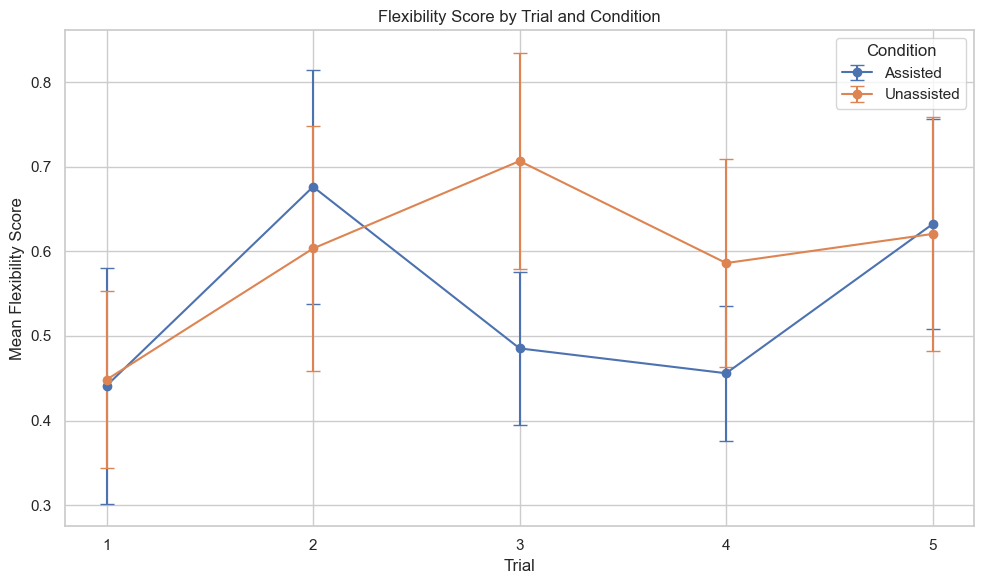

In [ ]:
plt.figure(figsize=(10, 6))
for condition in summary_flex['CombinedCondition'].unique():
    subset = summary_flex[summary_flex['CombinedCondition'] == condition]
    plt.errorbar(
        subset['Trial'],
        subset['mean_score'],
        yerr=subset['sem_score'],
        label=condition,
        marker='o',
        capsize=5
    )

plt.title('Flexibility Score by Trial and Condition')
plt.xlabel('Trial')
plt.ylabel('Mean Flexibility Score')
plt.xticks([1, 2, 3, 4, 5])
plt.legend(title='Condition')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot-images/flexibility_aut_over_time_combined_condition.png", dpi=300, bbox_inches='tight')
plt.show()


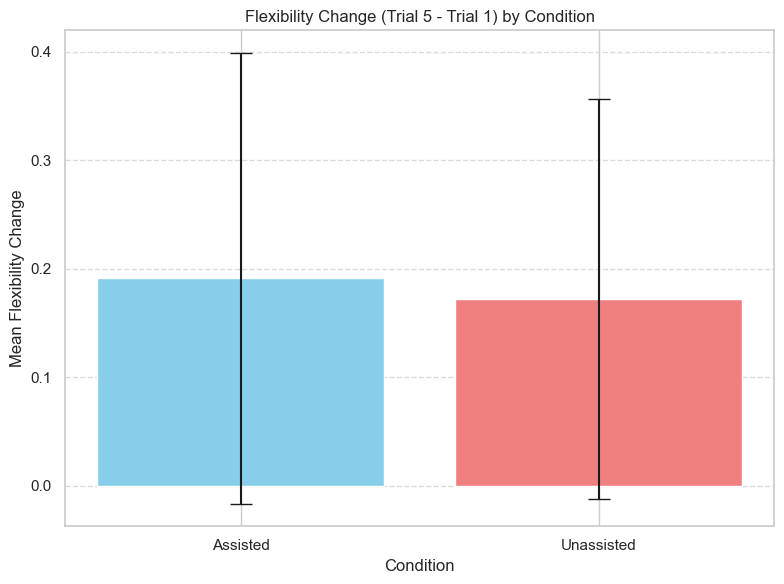

In [ ]:
# Calculate the change from Trial 1 to Trial 5
data["FlexibilityChange"] = data["Flexibility5"] - data["Flexibility1"]

# Group and summarize
change_summary = (
    data.groupby("CombinedCondition")["FlexibilityChange"]
    .agg(mean_change='mean', sem_change=lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(
    change_summary['CombinedCondition'],
    change_summary['mean_change'],
    yerr=change_summary['sem_change'],
    capsize=8,
    color=['skyblue', 'lightcoral']
)

plt.title("Flexibility Change (Trial 5 - Trial 1) by Condition")
plt.ylabel("Mean Flexibility Change")
plt.xlabel("Condition")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plot-images/flexibility_change_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Replace NaNs with 0
ai_assisted_aut = data[data['CombinedCondition'] == 'AI Assisted AUT']['FlexibilityChange'].fillna(0)
not_assisted_aut = data[data['CombinedCondition'] == 'Not AI Assisted AUT']['FlexibilityChange'].fillna(0)

# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_aut, not_assisted_aut)

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")


T-test result: t-statistic = nan, p-value = nan


/Users/sachinallums/Documents/GitHub/divergent-association-task/.venv/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


## Creative Self-Efficacy and Creative Personal Identity

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/3737235531.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="difference_creative_self_efficacy", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/3737235531.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="difference_creative_self_efficacy", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/3737235531.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="difference_creative_personal_identity", ax=axes[1], palette="Orange

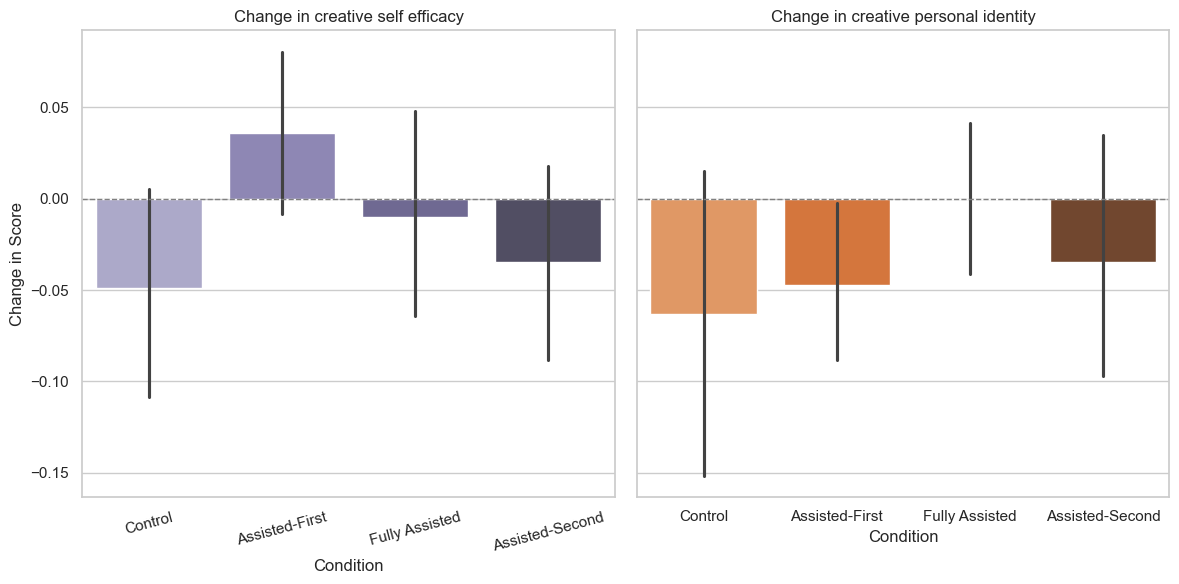

In [64]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Change in "AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="difference_creative_self_efficacy", ax=axes[0], palette="Purples_d", ci=95)
axes[0].set_title("Change in creative self efficacy")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Change in Score")
axes[0].tick_params(axis='x', rotation=15)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Change in "AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="difference_creative_personal_identity", ax=axes[1], palette="Oranges_d", ci=95)
axes[1].set_title("Change in creative personal identity")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/creative_self_efficacy_and_cpi.png", dpi=300, bbox_inches='tight')
plt.show()

In [65]:
# Perform ANOVA for change in creative self efficacy
anova_result_q44_2 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["difference_creative_self_efficacy"],
    data[data["AssignedCondition"] == "Fully Assisted"]["difference_creative_self_efficacy"],
    data[data["AssignedCondition"] == "Assisted-First"]["difference_creative_self_efficacy"],
    data[data["AssignedCondition"] == "Assisted-Second"]["difference_creative_self_efficacy"]
)

print("ANOVA for difference_creative_self_efficacy:")
print(anova_result_q44_2)

# Perform ANOVA for Q44_3 (I think AI can be useful in the creative process)
anova_result_q44_3 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["difference_creative_personal_identity"],
    data[data["AssignedCondition"] == "Fully Assisted"]["difference_creative_personal_identity"],
    data[data["AssignedCondition"] == "Assisted-First"]["difference_creative_personal_identity"],
    data[data["AssignedCondition"] == "Assisted-Second"]["difference_creative_personal_identity"]
    # Add more conditions as needed
)

print("\nANOVA for difference_creative_personal_identity:")
print(anova_result_q44_3)

# Create combined AI group
ai_group = data[data["AssignedCondition"].isin(["Fully Assisted", "Assisted-First", "Assisted-Second"])]["difference_creative_self_efficacy"]

# Control group
control_group = data[data["AssignedCondition"] == "Control"]["difference_creative_self_efficacy"]

# Welch’s t-test (doesn't assume equal variance)
t_stat, p_value = ttest_ind(ai_group, control_group, equal_var=False)

print("T-test: AI vs Control on creative self-efficacy change")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Assisted-First group
assisted_first = data[data["AssignedCondition"] == "Assisted-First"]["difference_creative_self_efficacy"]

# Control group
control = data[data["AssignedCondition"] == "Control"]["difference_creative_self_efficacy"]

# Welch’s t-test (safer for unequal sample sizes or variances)
t_stat, p_value = ttest_ind(assisted_first, control, equal_var=False)

print("T-test: Assisted-First vs Control on creative self-efficacy change")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")


# Combine Fully Assisted and Assisted-First groups
combined_group = data[data["AssignedCondition"].isin(["Fully Assisted", "Assisted-First"])]["difference_creative_self_efficacy"]

# Control group
control_group = data[data["AssignedCondition"] == "Control"]["difference_creative_self_efficacy"]

# Welch's t-test
t_stat, p_value = ttest_ind(combined_group, control_group, equal_var=False)

print("T-test: (Fully Assisted + Assisted-First) vs Control on creative self-efficacy change")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

ANOVA for difference_creative_self_efficacy:
F_onewayResult(statistic=np.float64(2.198490956271032), pvalue=np.float64(0.09167596149423882))

ANOVA for difference_creative_personal_identity:
F_onewayResult(statistic=np.float64(0.6053575063727445), pvalue=np.float64(0.6127520962334998))
T-test: AI vs Control on creative self-efficacy change
T-statistic: 1.4498389175859672, P-value: 0.15661012765179502
T-test: Assisted-First vs Control on creative self-efficacy change
T-statistic: 2.1976, P-value: 0.0333
T-test: (Fully Assisted + Assisted-First) vs Control on creative self-efficacy change
T-statistic: 1.9122, P-value: 0.0636


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1242824571.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=plot_data, x="AssignedCondition", y="Q39_1", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1242824571.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x="AssignedCondition", y="Q39_1", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1242824571.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=plot_data, x="AssignedCondition", y="Q39_2", ax=axes[1], palette="Greens_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_4322

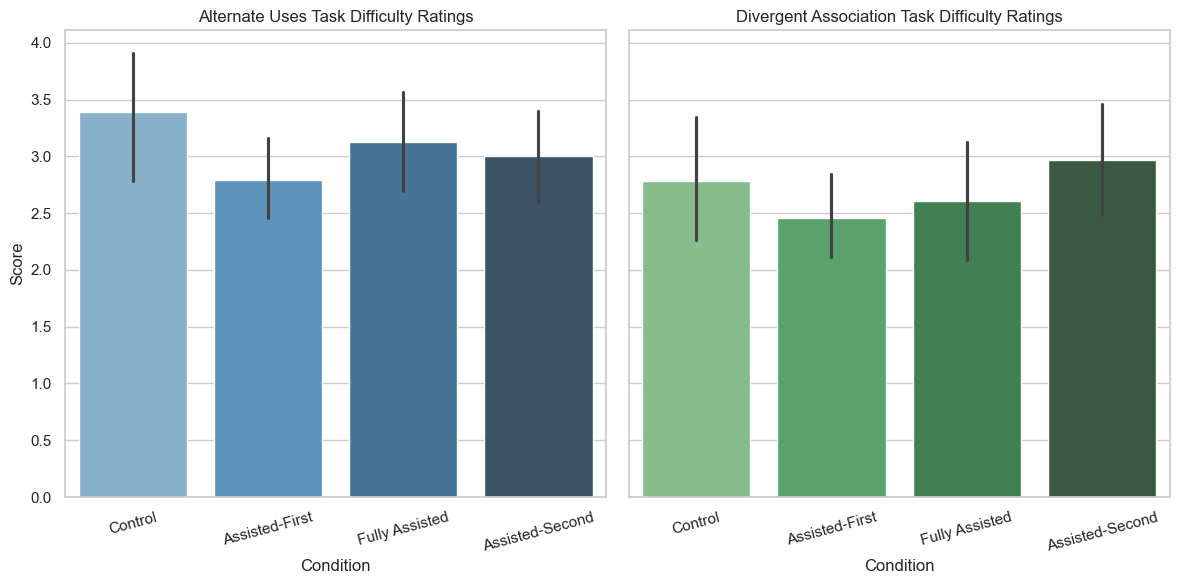

In [66]:
# Convert Q39_1 and Q39_2 to numeric, coercing any non-numeric values to NaN
data["Q39_1"] = pd.to_numeric(data["Q39_1"], errors="coerce")
data["Q39_2"] = pd.to_numeric(data["Q39_2"], errors="coerce")

# Drop rows with missing values in either column
plot_data = data.dropna(subset=["Q39_1", "Q39_2"])

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Q39_1: Felt Creative During Task
sns.barplot(data=plot_data, x="AssignedCondition", y="Q39_1", ax=axes[0], palette="Blues_d", ci=95)
axes[0].set_title("Alternate Uses Task Difficulty Ratings")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Score")
axes[0].tick_params(axis='x', rotation=15)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Q39_2: Task Helped Express Creativity
sns.barplot(data=plot_data, x="AssignedCondition", y="Q39_2", ax=axes[1], palette="Greens_d", ci=95)
axes[1].set_title("Divergent Association Task Difficulty Ratings")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', rotation=15)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/task_difficulty_ratings.png", dpi=300, bbox_inches='tight')
plt.show()

In [67]:
from scipy.stats import ttest_rel

# Convert to numeric and drop rows with missing values in either column
data["Q39_1"] = pd.to_numeric(data["Q39_1"], errors="coerce")
data["Q39_2"] = pd.to_numeric(data["Q39_2"], errors="coerce")

paired_data = data.dropna(subset=["Q39_1", "Q39_2"])

# Paired t-test
t_stat, p_val = ttest_rel(paired_data["Q39_1"], paired_data["Q39_2"])

print(paired_data["Q39_1"].mean(), "AUT Difficulty")
print(paired_data["Q39_2"].mean(), "DAT Difficulty")

# Print results
mean_diff = paired_data["Q39_1"].mean() - paired_data["Q39_2"].mean()
print(f"Mean Difference (Q39_1 - Q39_2): {mean_diff:.3f}")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.4f}")


3.024 AUT Difficulty
2.688 DAT Difficulty
Mean Difference (Q39_1 - Q39_2): 0.336
Paired t-test: t = 2.296, p = 0.0233


In [68]:
from scipy.stats import f_oneway
import pandas as pd

# Ensure numeric types
data["Q39_1"] = pd.to_numeric(data["Q39_1"], errors="coerce")
data["Q39_2"] = pd.to_numeric(data["Q39_2"], errors="coerce")

# Drop NaNs before analysis
q39_1_groups = [group["Q39_1"].dropna() for name, group in data.groupby("AssignedCondition")]
q39_2_groups = [group["Q39_2"].dropna() for name, group in data.groupby("AssignedCondition")]

# ANOVA for Q39_1
anova_q39_1 = f_oneway(*q39_1_groups)
print("ANOVA for Q39_1 (AUT Difficulty):")
print(f"F-statistic: {anova_q39_1.statistic:.3f}, p-value: {anova_q39_1.pvalue:.4f}\n")

# ANOVA for Q39_2
anova_q39_2 = f_oneway(*q39_2_groups)
print("ANOVA for Q39_2 (DAT DIfficulty):")
print(f"F-statistic: {anova_q39_2.statistic:.3f}, p-value: {anova_q39_2.pvalue:.4f}\n")

# Ensure Q39_1 is numeric
data["Q39_1"] = pd.to_numeric(data["Q39_1"], errors="coerce")

# 1. Assisted-First vs Control
assisted_first = data[data["AssignedCondition"] == "Assisted-First"]["Q39_1"].dropna()
control = data[data["AssignedCondition"] == "Control"]["Q39_1"].dropna()

t1_stat, t1_p = ttest_ind(assisted_first, control, equal_var=False)
print("T-test: Assisted-First vs Control on Q39_1")
print(f"T-statistic: {t1_stat:.3f}, p-value: {t1_p:.4f}\n")

# 2. (Assisted-First + Fully Assisted) vs (Control + Assisted-Second)
group_1 = data[data["AssignedCondition"].isin(["Assisted-First", "Fully Assisted"])]['Q39_1'].dropna()
group_2 = data[data["AssignedCondition"].isin(["Control", "Assisted-Second"])]['Q39_1'].dropna()

t2_stat, t2_p = ttest_ind(group_1, group_2, equal_var=False)
print("T-test: (Assisted-First + Fully Assisted) vs (Control + Assisted-Second) on Q39_1")
print(f"T-statistic: {t2_stat:.3f}, p-value: {t2_p:.4f}")


ANOVA for Q39_1 (AUT Difficulty):
F-statistic: 1.380, p-value: 0.2521

ANOVA for Q39_2 (DAT DIfficulty):
F-statistic: 1.014, p-value: 0.3893

T-test: Assisted-First vs Control on Q39_1
T-statistic: -1.816, p-value: 0.0770

T-test: (Assisted-First + Fully Assisted) vs (Control + Assisted-Second) on Q39_1
T-statistic: -1.179, p-value: 0.2409


## Reading Fluency Test

In [69]:
# Ensure numeric types
data['ReadingFluencyScore'] = pd.to_numeric(data['ReadingFluencyScore'], errors='coerce')
data['ReadingFluencyQuestionsSeen'] = pd.to_numeric(data['ReadingFluencyQuestionsSeen'], errors='coerce')
data['DATScore'] = pd.to_numeric(data['DATScore'], errors='coerce')

# Compute adjusted fluency score
data['AdjustedFluency'] = 2 * data['ReadingFluencyScore'] - data['ReadingFluencyQuestionsSeen']

data_old = data

print("Old number of participants", data_old.shape[0])

# Convert to numeric
data['ReadingFluencyScore'] = pd.to_numeric(data['ReadingFluencyScore'], errors='coerce')
data['ReadingFluencyQuestionsSeen'] = pd.to_numeric(data['ReadingFluencyQuestionsSeen'], errors='coerce')
data['DATScore'] = pd.to_numeric(data['DATScore'], errors='coerce')

# # Filter out rows where ReadingFluencyQuestionsSeen is 140
# data = data[data['ReadingFluencyQuestionsSeen'] != 140]

print("New number of participants with random clicking", data.shape[0])

Old number of participants 126
New number of participants with random clicking 126


Pearson correlation: r = 0.206, p = 0.021


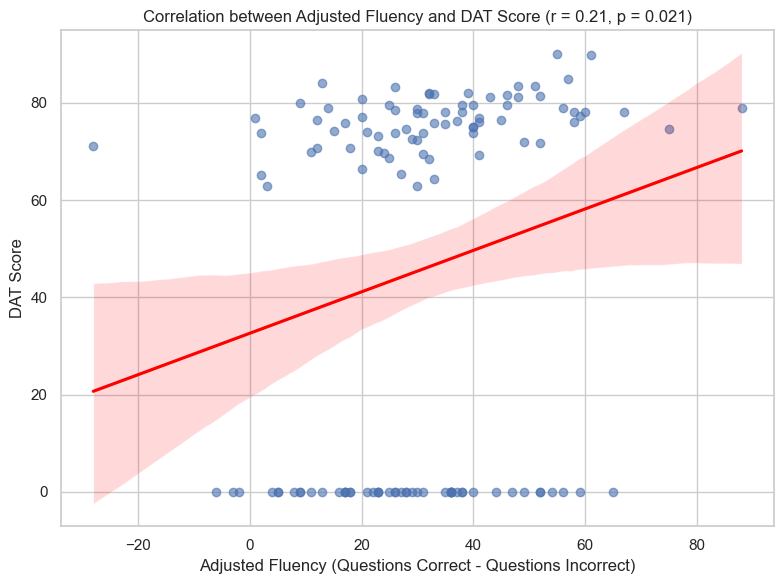

In [70]:
# Ensure numeric types
data['ReadingFluencyScore'] = pd.to_numeric(data['ReadingFluencyScore'], errors='coerce')
data['ReadingFluencyQuestionsSeen'] = pd.to_numeric(data['ReadingFluencyQuestionsSeen'], errors='coerce')
data['DATScore'] = pd.to_numeric(data['DATScore'], errors='coerce')

# Compute adjusted fluency score
data['AdjustedFluency'] = 2 * data['ReadingFluencyScore'] - data['ReadingFluencyQuestionsSeen']

# Drop rows with missing values
clean_data = data[['AdjustedFluency', 'DATScore']].dropna()

# Compute correlation
r, p = pearsonr(clean_data['AdjustedFluency'], clean_data['DATScore'])
print(f"Pearson correlation: r = {r:.3f}, p = {p:.3f}")

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(
    data=clean_data,
    x='AdjustedFluency',
    y='DATScore',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title(f'Correlation between Adjusted Fluency and DAT Score (r = {r:.2f}, p = {p:.3f})')
plt.xlabel('Adjusted Fluency (Questions Correct - Questions Incorrect)')
plt.ylabel('DAT Score')
plt.tight_layout()
plt.savefig("plot-images/adjustedfluency_vs_datscore.png", dpi=300)
plt.show()


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/4139312631.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="AdjustedFluency", palette="viridis", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/4139312631.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="AdjustedFluency", palette="viridis", ci=95)


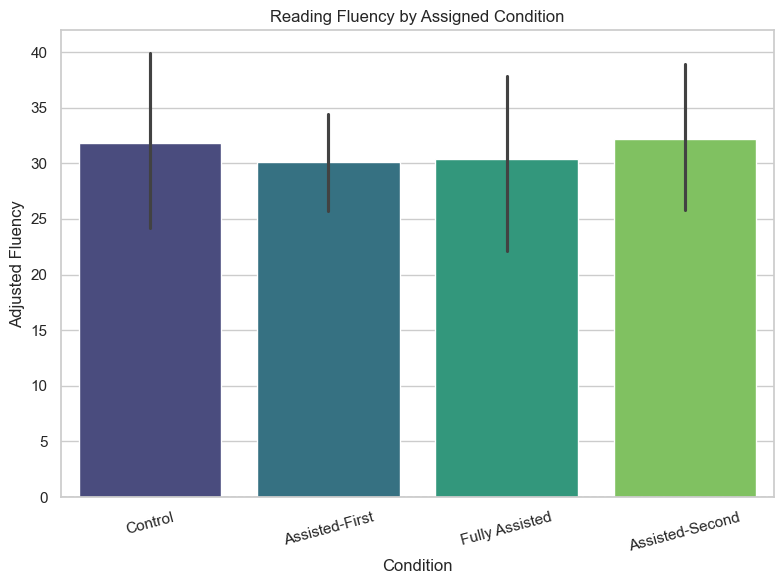

In [84]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="AdjustedFluency", palette="viridis", ci=95)

plt.title("Reading Fluency by Assigned Condition")
plt.xlabel("Condition")
plt.ylabel("Adjusted Fluency")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/reading_fluency_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()


In [85]:
# Split into groups
grouped = data.groupby("AssignedCondition")["AdjustedFluency"]
group_values = [group for name, group in grouped]

# Run ANOVA
f_stat, p_val = f_oneway(*group_values)

# Print results
print("One-Way ANOVA: Adjusted Fluency by Assigned Condition")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4f}")

One-Way ANOVA: Adjusted Fluency by Assigned Condition
F-statistic: 0.1086
P-value: 0.9550


## Digit Span Analysis

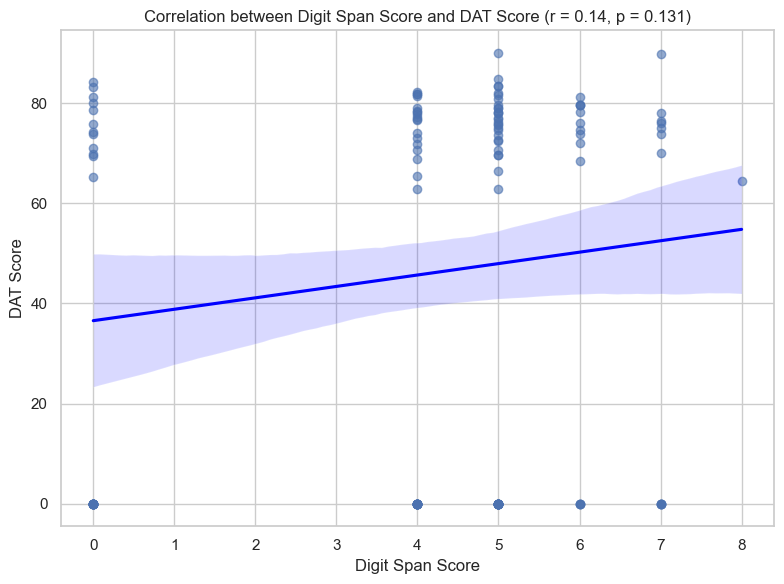

In [71]:
data = data_old

# Drop missing values
data['DigitSpanScore'] = data['DigitSpanScore'].fillna(0)
data['DATScore'] = data['DATScore'].fillna(0)

clean_data = data[['DigitSpanScore', 'DATScore']].dropna()

# Pearson correlation
r, p = pearsonr(clean_data['DigitSpanScore'], clean_data['DATScore'])

plt.figure(figsize=(8, 6))
sns.regplot(
    data=clean_data, 
    x='DigitSpanScore', 
    y='DATScore', 
    scatter_kws={'alpha': 0.6}, 
    line_kws={'color': 'blue'}
)
plt.title(f'Correlation between Digit Span Score and DAT Score (r = {r:.2f}, p = {p:.3f})')
plt.xlabel('Digit Span Score')
plt.ylabel('DAT Score')
plt.tight_layout()
plt.savefig("plot-images/digitspan_vs_datscore.png", dpi=300)
plt.show()


In [82]:
# Group data by AssignedCondition
groups = data.groupby("AssignedCondition")["DigitSpanScore"]

# Extract scores for each group
group_scores = [group.tolist() for name, group in groups]

# Run one-way ANOVA
f_stat, p_value = f_oneway(*group_scores)

print(f"ANOVA results: F = {f_stat:.4f}, p = {p_value:.4f}")

print(data.shape)

ANOVA results: F = 1.8500, p = 0.1417
(126, 350)


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1816296359.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DigitSpanScore", ci=95, palette="muted")
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1816296359.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DigitSpanScore", ci=95, palette="muted")


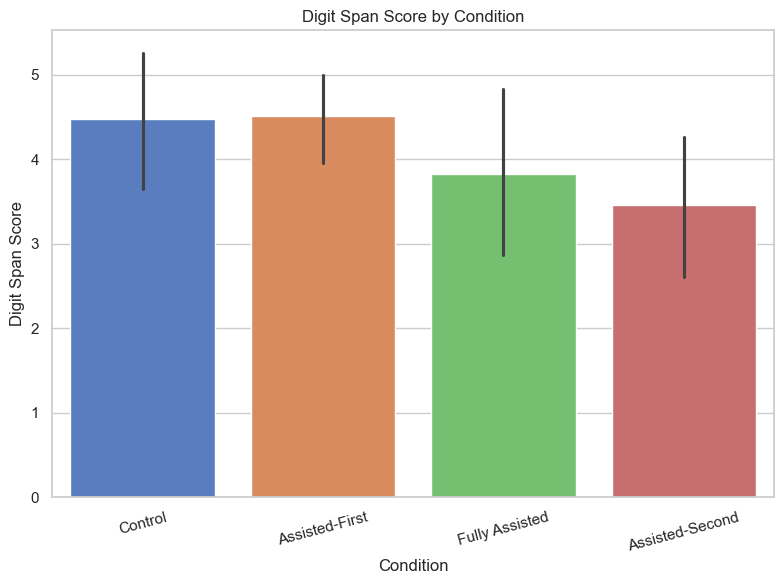

In [83]:
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x="AssignedCondition", y="DigitSpanScore", ci=95, palette="muted")
plt.title("Digit Span Score by Condition")
plt.xlabel("Condition")
plt.ylabel("Digit Span Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("plot-images/digitspan_by_condition.png", dpi=300)
plt.show()


In [74]:

# Group by AssignedCondition and calculate mean and std
group_stats = data.groupby("AssignedCondition")["DigitSpanScore"].agg(['mean', 'std', 'count']).reset_index()

# Round for cleaner output
group_stats = group_stats.round(2)

# Print results
print(group_stats)


  AssignedCondition  mean   std  count
0    Assisted-First  4.51  1.85     45
1   Assisted-Second  3.46  2.52     35
2           Control  4.48  2.04     23
3    Fully Assisted  3.83  2.48     23


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/150423865.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/150423865.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


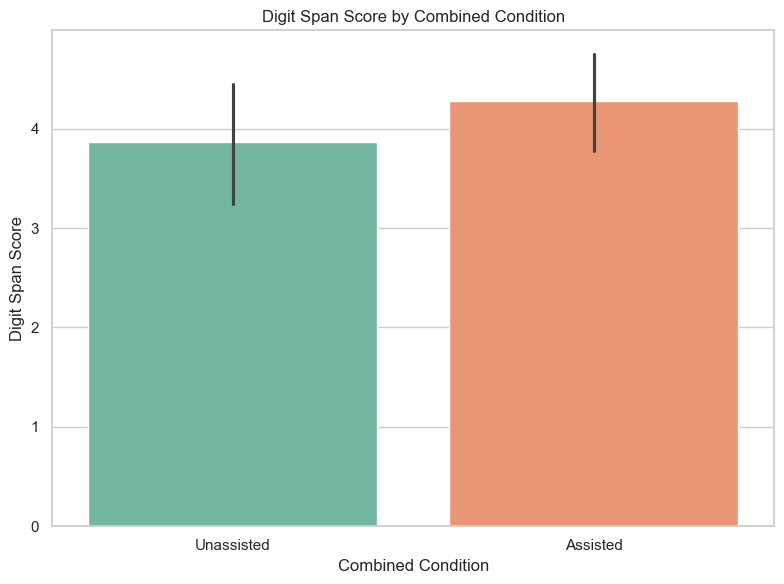

In [75]:

# Step 2: Define combined condition
def combine_condition(cond):
    if cond in ["Control", "Assisted-Second"]:
        return "Unassisted"
    elif cond in ["Assisted-First", "Fully Assisted"]:
        return "Assisted"
    else:
        return "Other"

data["CombinedCondition"] = data["AssignedCondition"].apply(combine_condition)

# Step 3: Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(
    data=data,
    x="CombinedCondition",
    y="DigitSpanScore",
    palette="Set2",
    ci=95
)

plt.title("Digit Span Score by Combined Condition")
plt.xlabel("Combined Condition")
plt.ylabel("Digit Span Score")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig("plot-images/digit_span_by_combined_condition.png", dpi=300, bbox_inches='tight')
plt.show()


In [76]:
# Split data into two groups
assisted_group = data[data["CombinedCondition"] == "Assisted"]["DigitSpanScore"]
unassisted_group = data[data["CombinedCondition"] == "Unassisted"]["DigitSpanScore"]

# Run independent t-test
t_stat, p_value = ttest_ind(assisted_group, unassisted_group, equal_var=False)  # Welch's t-test

# Print results
print("Independent Samples T-Test (Assisted vs Unassisted):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Independent Samples T-Test (Assisted vs Unassisted):
T-statistic: 1.0365
P-value: 0.3022


## Other Paper: SES and Literacy Correlations

In [77]:
# Ensure Q240 is numeric (if it's not already)
data['Q240'] = pd.to_numeric(data['Q240'], errors='coerce')

# Create highSES column: 0 if Q240 is 0 or 1, else 1
data['highSES'] = data['Q240'].apply(lambda x: 0 if x in [0, 1] else 1)

# Optional: check value counts
print(data['highSES'].value_counts())


highSES
0    93
1    33
Name: count, dtype: int64


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1125003754.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(data=plot_data, x='Group', y='DATScore', ci=95, palette='pastel', order=order)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1125003754.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data, x='Group', y='DATScore', ci=95, palette='pastel', order=order)


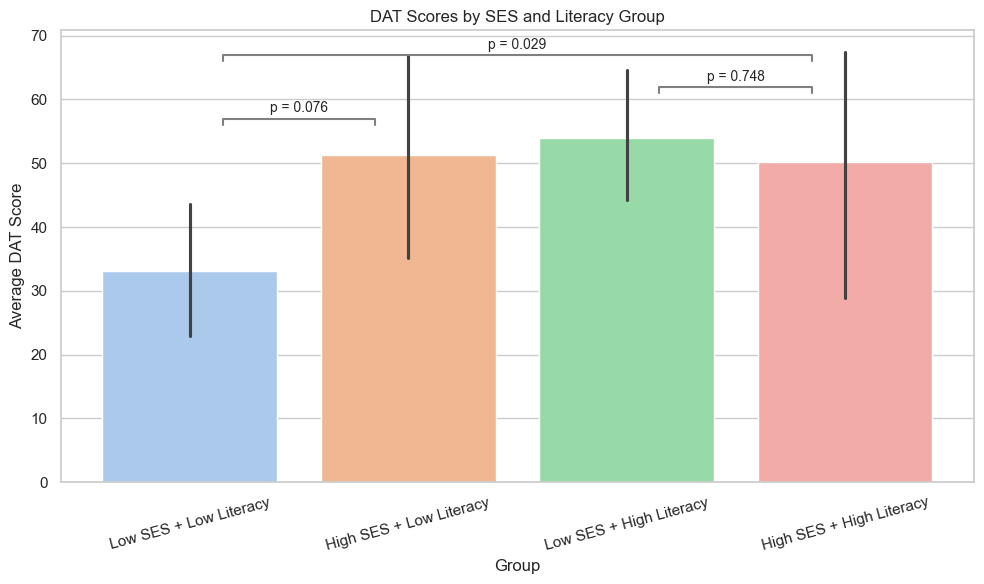

In [78]:
# Median split
data = data.copy()
median_fluency = data['AdjustedFluency'].median()
data['LiteracyGroup'] = data['AdjustedFluency'].apply(lambda x: 'highLiteracy' if x >= median_fluency else 'lowLiteracy')

# Create group labels
def label_group(row):
    if row['highSES'] == 0 and row['LiteracyGroup'] == 'lowLiteracy':
        return 'Low SES + Low Literacy'
    elif row['highSES'] == 1 and row['LiteracyGroup'] == 'lowLiteracy':
        return 'High SES + Low Literacy'
    elif row['highSES'] == 0 and row['LiteracyGroup'] == 'highLiteracy':
        return 'Low SES + High Literacy'
    else:
        return 'High SES + High Literacy'

data['Group'] = data.apply(label_group, axis=1)

# Filter out rows with missing group or DATScore
plot_data = data[['Group', 'DATScore']].dropna()

order = ['Low SES + Low Literacy', 'High SES + Low Literacy', 'Low SES + High Literacy', 'High SES + High Literacy']

# Plot with error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_data, x='Group', y='DATScore', ci=95, palette='pastel', order=order)
plt.ylabel('Average DAT Score')
plt.title('DAT Scores by SES and Literacy Group')
plt.xticks(rotation=15)

# T-tests
i = data[(data['highSES'] == 0) & (data['LiteracyGroup'] == 'lowLiteracy')]['DATScore']
ii = data[(data['highSES'] == 1) & (data['LiteracyGroup'] == 'lowLiteracy')]['DATScore']
iii = data[(data['highSES'] == 0) & (data['LiteracyGroup'] == 'highLiteracy')]['DATScore']
iv = data[(data['highSES'] == 1) & (data['LiteracyGroup'] == 'highLiteracy')]['DATScore']

# Run t-tests
t1, p1 = ttest_ind(i.dropna(), ii.dropna(), equal_var=False)
t2, p2 = ttest_ind(iii.dropna(), iv.dropna(), equal_var=False)
t3, p3 = ttest_ind(pd.concat([i, ii]).dropna(), pd.concat([iii, iv]).dropna(), equal_var=False)

# Add significance brackets and p-values
def add_bracket(ax, x1, x2, y, text):
    ax.plot([x1 + .15, x1 + .15, x2 - .15, x2 - .15], [y, y + 1, y + 1, y], lw=1.5, c='gray')
    ax.text((x1 + x2) * 0.5, y + 1.5, text, ha='center', va='bottom', fontsize=10)

# Get bar heights to determine bracket placement
bar_heights = [patch.get_height() for patch in ax.patches]
max_height = max(bar_heights)

# Add brackets
add_bracket(ax, 0, 1, max_height + 2, f"p = {p1:.3f}")
add_bracket(ax, 2, 3, max_height + 7, f"p = {p2:.3f}")
add_bracket(ax, 0, 3, max_height + 12, f"p = {p3:.3f}")

plt.tight_layout()
plt.savefig('plot-images/DATScore_by_SES_Literacy_Group.png', dpi=300)
plt.show()


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2128520975.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(data=plot_data, x='Group', y='FluencyAverage', ci=95, palette='pastel', order=order)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/2128520975.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data, x='Group', y='FluencyAverage', ci=95, palette='pastel', order=order)


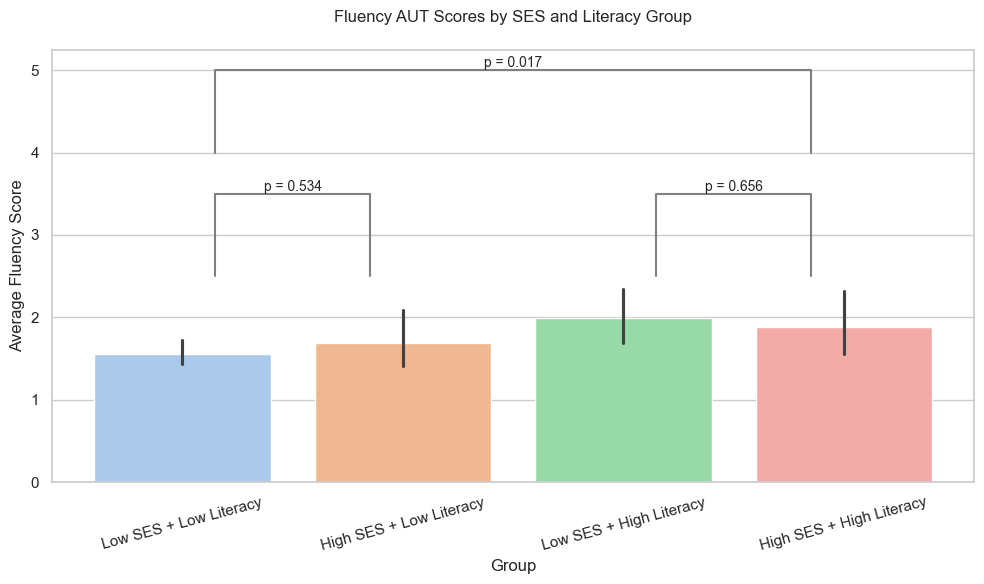

In [79]:
# FLUENCY ON THE AUT

# Median split
data = data.copy()
median_fluency = data['AdjustedFluency'].median()
data['LiteracyGroup'] = data['AdjustedFluency'].apply(lambda x: 'highLiteracy' if x >= median_fluency else 'lowLiteracy')

# Create group labels
def label_group(row):
    if row['highSES'] == 0 and row['LiteracyGroup'] == 'lowLiteracy':
        return 'Low SES + Low Literacy'
    elif row['highSES'] == 1 and row['LiteracyGroup'] == 'lowLiteracy':
        return 'High SES + Low Literacy'
    elif row['highSES'] == 0 and row['LiteracyGroup'] == 'highLiteracy':
        return 'Low SES + High Literacy'
    else:
        return 'High SES + High Literacy'

data['Group'] = data.apply(label_group, axis=1)

# Filter out rows with missing group or FluencyAverage
plot_data = data[['Group', 'FluencyAverage']].dropna()

order = ['Low SES + Low Literacy', 'High SES + Low Literacy', 'Low SES + High Literacy', 'High SES + High Literacy']

# Plot with error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_data, x='Group', y='FluencyAverage', ci=95, palette='pastel', order=order)
plt.ylabel('Average Fluency Score')
plt.title('Fluency AUT Scores by SES and Literacy Group', pad=20)
plt.xticks(rotation=15)

# T-tests
i = data[(data['highSES'] == 0) & (data['LiteracyGroup'] == 'lowLiteracy')]['FluencyAverage']
ii = data[(data['highSES'] == 1) & (data['LiteracyGroup'] == 'lowLiteracy')]['FluencyAverage']
iii = data[(data['highSES'] == 0) & (data['LiteracyGroup'] == 'highLiteracy')]['FluencyAverage']
iv = data[(data['highSES'] == 1) & (data['LiteracyGroup'] == 'highLiteracy')]['FluencyAverage']

# Run t-tests
t1, p1 = ttest_ind(i.dropna(), ii.dropna(), equal_var=False)
t2, p2 = ttest_ind(iii.dropna(), iv.dropna(), equal_var=False)
t3, p3 = ttest_ind(pd.concat([i, ii]).dropna(), pd.concat([iii, iv]).dropna(), equal_var=False)

# Add significance brackets and p-values
def add_bracket(ax, x1, x2, y, text):
    ax.plot([x1 + .15, x1 + .15, x2 - .15, x2 - .15], [y, y + 1, y + 1, y], lw=1.5, c='gray')
    ax.text((x1 + x2) * 0.5, y + 1, text, ha='center', va='bottom', fontsize=10)

# Get bar heights to determine bracket placement
bar_heights = [patch.get_height() for patch in ax.patches]
max_height = max(bar_heights)

# Add brackets
add_bracket(ax, 0, 1, max_height + .5, f"p = {p1:.3f}")
add_bracket(ax, 2, 3, max_height + .5, f"p = {p2:.3f}")
add_bracket(ax, 0, 3, max_height + 2, f"p = {p3:.3f}")

plt.tight_layout()
plt.savefig('plot-images/FluencyScore_by_SES_Literacy_Group.png', dpi=300)
plt.show()


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1904442376.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax1 = sns.barplot(data=plot_data1, x='Group', y='FluencyAverage', ci=95, palette='pastel', order=order, ax=axes[0])


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1904442376.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=plot_data1, x='Group', y='FluencyAverage', ci=95, palette='pastel', order=order, ax=axes[0])
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1904442376.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/1904442376.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax2 = sns.barplot(data=plot_data2, x='Group', y='DATScore', ci=95, palette='pastel', order=order, ax=axes[1])
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipyk

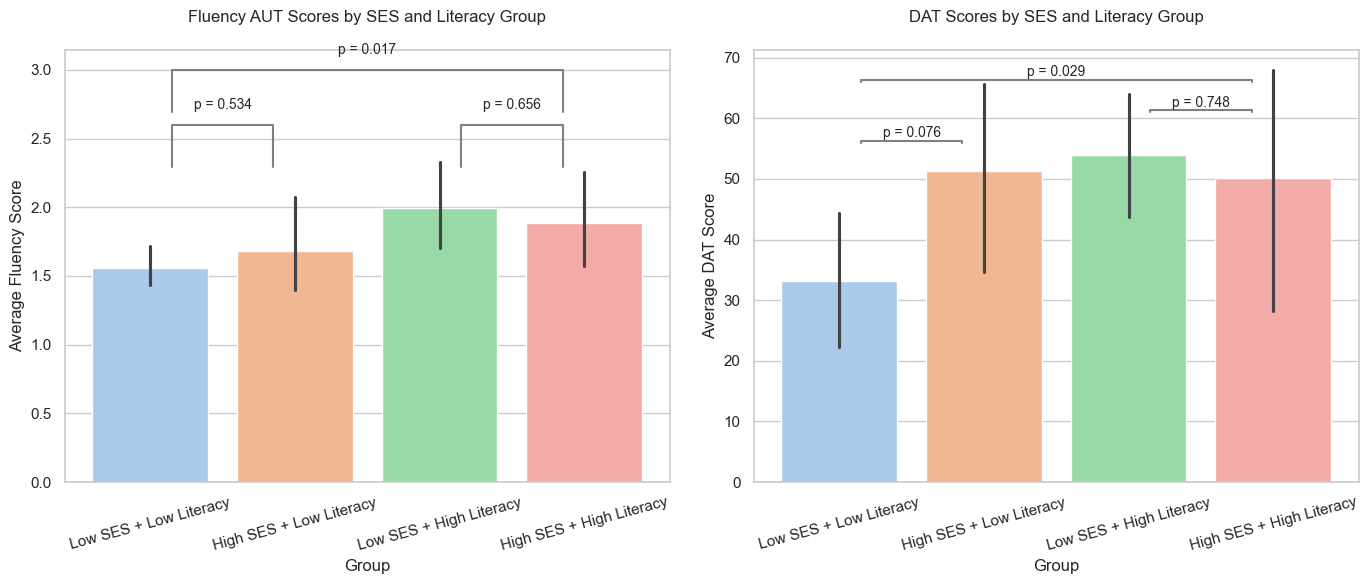

In [80]:
# Median split
data = data.copy()
median_fluency = data['AdjustedFluency'].median()
data['LiteracyGroup'] = data['AdjustedFluency'].apply(lambda x: 'highLiteracy' if x >= median_fluency else 'lowLiteracy')

# Create group labels
def label_group(row):
    if row['highSES'] == 0 and row['LiteracyGroup'] == 'lowLiteracy':
        return 'Low SES + Low Literacy'
    elif row['highSES'] == 1 and row['LiteracyGroup'] == 'lowLiteracy':
        return 'High SES + Low Literacy'
    elif row['highSES'] == 0 and row['LiteracyGroup'] == 'highLiteracy':
        return 'Low SES + High Literacy'
    else:
        return 'High SES + High Literacy'

data['Group'] = data.apply(label_group, axis=1)
order = ['Low SES + Low Literacy', 'High SES + Low Literacy', 'Low SES + High Literacy', 'High SES + High Literacy']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# -------- PLOT 1: Fluency --------
plot_data1 = data[['Group', 'FluencyAverage']].dropna()
ax1 = sns.barplot(data=plot_data1, x='Group', y='FluencyAverage', ci=95, palette='pastel', order=order, ax=axes[0])
ax1.set_ylabel('Average Fluency Score')
ax1.set_title('Fluency AUT Scores by SES and Literacy Group', pad=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

# T-tests
i = data[(data['highSES'] == 0) & (data['LiteracyGroup'] == 'lowLiteracy')]['FluencyAverage']
ii = data[(data['highSES'] == 1) & (data['LiteracyGroup'] == 'lowLiteracy')]['FluencyAverage']
iii = data[(data['highSES'] == 0) & (data['LiteracyGroup'] == 'highLiteracy')]['FluencyAverage']
iv = data[(data['highSES'] == 1) & (data['LiteracyGroup'] == 'highLiteracy')]['FluencyAverage']
_, p1 = ttest_ind(i.dropna(), ii.dropna(), equal_var=False)
_, p2 = ttest_ind(iii.dropna(), iv.dropna(), equal_var=False)
_, p3 = ttest_ind(pd.concat([i, ii]).dropna(), pd.concat([iii, iv]).dropna(), equal_var=False)

# Add significance brackets
def add_bracket(ax, x1, x2, y, text, height=0.3, offset=0.1):
    ax.plot([x1 + .15, x1 + .15, x2 - .15, x2 - .15], [y, y + height, y + height, y], lw=1.5, c='gray')
    ax.text((x1 + x2) * 0.5, y + height + offset, text, ha='center', va='bottom', fontsize=10)

bar_heights1 = [patch.get_height() for patch in ax1.patches]
max1 = max(bar_heights1)
add_bracket(ax1, 0, 1, max1 + 0.3, f"p = {p1:.3f}")
add_bracket(ax1, 2, 3, max1 + 0.3, f"p = {p2:.3f}")
add_bracket(ax1, 0, 3, max1 + 0.7, f"p = {p3:.3f}")

# -------- PLOT 2: DAT Score --------
plot_data2 = data[['Group', 'DATScore']].dropna()
ax2 = sns.barplot(data=plot_data2, x='Group', y='DATScore', ci=95, palette='pastel', order=order, ax=axes[1])
ax2.set_ylabel('Average DAT Score')
ax2.set_title('DAT Scores by SES and Literacy Group', pad=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15)

i = data[(data['highSES'] == 0) & (data['LiteracyGroup'] == 'lowLiteracy')]['DATScore']
ii = data[(data['highSES'] == 1) & (data['LiteracyGroup'] == 'lowLiteracy')]['DATScore']
iii = data[(data['highSES'] == 0) & (data['LiteracyGroup'] == 'highLiteracy')]['DATScore']
iv = data[(data['highSES'] == 1) & (data['LiteracyGroup'] == 'highLiteracy')]['DATScore']
_, p4 = ttest_ind(i.dropna(), ii.dropna(), equal_var=False)
_, p5 = ttest_ind(iii.dropna(), iv.dropna(), equal_var=False)
_, p6 = ttest_ind(pd.concat([i, ii]).dropna(), pd.concat([iii, iv]).dropna(), equal_var=False)

bar_heights2 = [patch.get_height() for patch in ax2.patches]
max2 = max(bar_heights2)
add_bracket(ax2, 0, 1, max2 + 2, f"p = {p4:.3f}")
add_bracket(ax2, 2, 3, max2 + 7, f"p = {p5:.3f}")
add_bracket(ax2, 0, 3, max2 + 12, f"p = {p6:.3f}")

plt.tight_layout()
plt.savefig('plot-images/Fluency_and_DATScore_by_SES_Literacy_Group.png', dpi=300)
plt.show()


## Average Age of Groups

In [ ]:
grade_counts = data['Q4'].value_counts()
print(grade_counts)

Q4
7th      51
6th      33
9th      24
8th      17
Other     1
Name: count, dtype: int64


## Prior AI Use

In [92]:
# Overall mean
overall_mean = data['Q26_2'].mean()
print("Overall mean of Using AI in everyday life:", overall_mean)

# Mean by AssignedCondition
mean_by_condition = data.groupby('AssignedCondition')['Q26_2'].mean()
print("\nMean of AI use in everyday life by AssignedCondition:")
print(mean_by_condition)

Overall mean of Using AI in everyday life: 2.6370967741935485

Mean of AI use in everyday life by AssignedCondition:
AssignedCondition
Assisted-First     2.044444
Assisted-Second    2.882353
Control            2.863636
Fully Assisted     3.217391
Name: Q26_2, dtype: float64


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/3418614366.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=filtered_df, x='AssignedCondition', y='Q26_2', ci='sd', palette='Set2')
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_43225/3418614366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_df, x='AssignedCondition', y='Q26_2', ci='sd', palette='Set2')


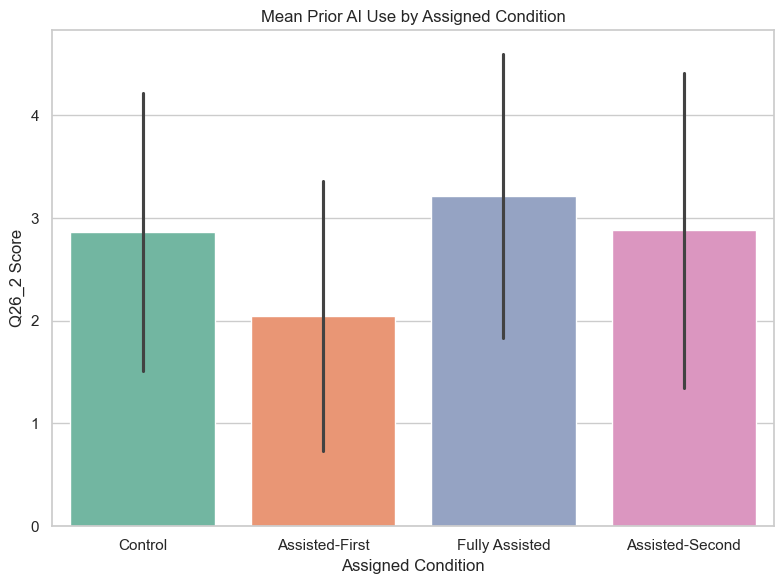

ANOVA results:
F-statistic = 4.569, p-value = 0.0046


In [100]:
# Drop rows with missing values in relevant columns
filtered_df = data[['Q26_2', 'AssignedCondition']].dropna()

# --- Plotting ---
plt.figure(figsize=(8, 6))
sns.barplot(data=filtered_df, x='AssignedCondition', y='Q26_2', ci='sd', palette='Set2')
plt.title('Mean Prior AI Use by Assigned Condition')
plt.ylabel('Q26_2 Score')
plt.xlabel('Assigned Condition')
plt.tight_layout()
plt.show()

# --- ANOVA ---
# Prepare data for each condition
groups = [group['Q26_2'].values for name, group in filtered_df.groupby('AssignedCondition')]

# Run one-way ANOVA
f_stat, p_value = f_oneway(*groups)

print(f"ANOVA results:\nF-statistic = {f_stat:.3f}, p-value = {p_value:.4f}")


In [99]:
# Drop missing values
filtered_df = data[['Q26_2', 'AssignedCondition']].dropna()

# Get the Assisted-First group
assisted_group = filtered_df[filtered_df['AssignedCondition'] == 'Assisted-First']['Q26_2']

# Run t-tests against every other group
other_conditions = filtered_df['AssignedCondition'].unique()
other_conditions = [cond for cond in other_conditions if cond != 'Assisted-First']

print("T-test results comparing Assisted-First to other conditions:\n")
for condition in other_conditions:
    group = filtered_df[filtered_df['AssignedCondition'] == condition]['Q26_2']
    t_stat, p_val = ttest_ind(assisted_group, group, equal_var=False)  # Welch's t-test
    print(f"Assisted-First vs {condition} -> t = {t_stat:.3f}, p = {p_val:.4f}")


T-test results comparing Assisted-First to other conditions:

Assisted-First vs Control -> t = -2.347, p = 0.0239
Assisted-First vs Fully Assisted -> t = -3.370, p = 0.0016
Assisted-First vs Assisted-Second -> t = -2.556, p = 0.0129


In [101]:
data.to_csv('updated_data.csv')